In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('./src/analysis')
sys.path.append('./src/data_handling')
sys.path.append('./src/modeling')
sys.path.append('./src/prediction')
sys.path.append('./src/visualization')
from analyzer import FeatureAnalyzer
from selector import FeatureSelector
from aggregator import DataAggregator
from feature_engineer import BatteryFeatureEngineer
from reader import BatteryDataReader
from cross_validator import CrossValidator
from evaluator import ModelEvaluator
from trainer import ModelTrainer
from predictor import Predictor
from visualizer import ResultVisualizer


In [2]:
battery_ids = ['B0005', 'B0006', 'B0007', 'B0018']
ACTUAL_DATA_DIR = "./dataset/"

# Update config for feature engineering
fe_configuration = {
    # Update config
}

# Init object
aggregator_df = DataAggregator(
    battery_ids=battery_ids,
    data_dir=ACTUAL_DATA_DIR,
    fe_config=fe_configuration
)

In [3]:
# Aggregator data
aggregator_df.aggregate(force_rerun=True)

# Get data aggregator
df_combined = aggregator_df.get_combined_data()

# Check data combined
df_combined.head()


--- Starting Data Aggregation for Batteries: ['B0006', 'B0005', 'B0007', 'B0018'] ---


Aggregating Batteries:   0%|          | 0/4 [00:00<?, ?it/s]


--- Processing: B0006 ---
--- Loading data for battery: B0006 ---
  Successfully loaded: capacity_B0006.csv
  Successfully loaded: charge_B0006.csv
  Successfully loaded: discharge_B0006.csv
--- Data loading process completed for B0006 ---
  Ensuring numeric types for B0006...
--- Starting Feature Engineering process for B0006 ---
  Calculating SOH/RUL for B0006...
  Engineering discharge features for B0006...


  Engineering charge features for B0006...


Aggregating Batteries:  25%|██▌       | 1/4 [00:00<00:02,  1.14it/s]

  Merging features for B0006...
  Handling NaNs for B0006...
--- Feature Engineering process finished for B0006 ---
  Successfully processed B0006. Shape: (168, 13)

--- Processing: B0005 ---
--- Loading data for battery: B0005 ---
  Successfully loaded: capacity_B0005.csv
  Successfully loaded: charge_B0005.csv
  Successfully loaded: discharge_B0005.csv
--- Data loading process completed for B0005 ---
  Ensuring numeric types for B0005...
--- Starting Feature Engineering process for B0005 ---
  Calculating SOH/RUL for B0005...
  Engineering discharge features for B0005...


  Engineering charge features for B0005...


Aggregating Batteries:  50%|█████     | 2/4 [00:01<00:01,  1.23it/s]

  Merging features for B0005...
  Handling NaNs for B0005...
--- Feature Engineering process finished for B0005 ---
  Successfully processed B0005. Shape: (168, 13)

--- Processing: B0007 ---
--- Loading data for battery: B0007 ---
  Successfully loaded: capacity_B0007.csv
  Successfully loaded: charge_B0007.csv
  Successfully loaded: discharge_B0007.csv
--- Data loading process completed for B0007 ---
  Ensuring numeric types for B0007...
--- Starting Feature Engineering process for B0007 ---
  Calculating SOH/RUL for B0007...
    Note: Battery B0007 did not reach EoL threshold (1.32 Ah). Using 169 for RUL.
  Engineering discharge features for B0007...


  Engineering charge features for B0007...


Aggregating Batteries:  75%|███████▌  | 3/4 [00:02<00:00,  1.27it/s]

  Merging features for B0007...
  Handling NaNs for B0007...
--- Feature Engineering process finished for B0007 ---
  Successfully processed B0007. Shape: (168, 13)

--- Processing: B0018 ---
--- Loading data for battery: B0018 ---
  Successfully loaded: capacity_B0018.csv
  Successfully loaded: charge_B0018.csv
  Successfully loaded: discharge_B0018.csv
--- Data loading process completed for B0018 ---
  Ensuring numeric types for B0018...
--- Starting Feature Engineering process for B0018 ---
  Calculating SOH/RUL for B0018...
    Note: Battery B0018 did not reach EoL threshold (1.30 Ah). Using 133 for RUL.
  Engineering discharge features for B0018...


  Engineering charge features for B0018...


Aggregating Batteries: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

  Merging features for B0018...
  Handling NaNs for B0018...
--- Feature Engineering process finished for B0018 ---
  Successfully processed B0018. Shape: (132, 13)

--- Concatenating data from all processed batteries ---
Combined DataFrame shape: (636, 13)
Unique batteries in combined data: ['B0006' 'B0005' 'B0007' 'B0018']

--- Performing final NaN check and fill on combined data ---
No NaNs found in the combined data after individual processing.
--- Data Aggregation Finished ---


,cycle,capacity,SOH,RUL,Discharge_V_median,Discharge_V_skew,Discharge_T_delta,Discharge_T_std,Charge_T_std,Time_CC_phase,Time_CV_phase,CV_I_end,battery_id
0,1,2.035338,100.000000,101,3.548989,-1.019780,14.885913,3.460482,0.985631,439.438,6739.937,-0.004522,B0006
1,2,2.025140,99.498985,100,3.554208,-1.295688,14.607964,3.404115,1.710039,3224.844,6792.750,-0.001965,B0006
2,3,2.013326,98.918547,99,3.556400,-1.061351,14.295145,3.358434,1.758008,3221.765,6765.344,-0.003012,B0006
3,4,2.013285,98.916498,98,3.557417,-0.971438,14.195243,3.349620,1.752708,3189.625,6713.781,0.001331,B0006
4,5,2.000528,98.289755,97,3.556609,-1.415468,14.343783,3.344364,1.772646,3166.015,6849.922,0.018652,B0006


In [4]:
def replace_outlier(df_processed,column_names, thresholds):
    for column_name, threshold in zip(column_names, thresholds):
        indices_below_threshold = df_processed.index[df_processed[column_name] < threshold].tolist()

        print(f"\nCác index có giá trị < {threshold}: {indices_below_threshold}")

        for idx in indices_below_threshold:
            # Kiểm tra xem có phải là hàng cuối cùng không
            if idx < len(df_processed) - 1:
                value_after = df_processed.loc[idx + 1, column_name]
                print(f" - Tại index {idx}, giá trị gốc là {df_processed.loc[idx, column_name]}.Thay bằng : {value_after}")
                df_processed.loc[idx, column_name] = value_after

In [5]:
df_combined_copy = df_combined.copy()

In [8]:
replace_outlier(df_combined_copy, ['Time_CV_phase', 'Time_CC_phase', 'Charge_T_std'],[6000, 500, 0.7])


Các index có giá trị < 6000: []

Các index có giá trị < 500: []

Các index có giá trị < 0.7: []


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [10]:
features_to_scale = ['Discharge_V_median', 'Discharge_V_skew','Discharge_T_delta','Discharge_T_std','Charge_T_std','Time_CC_phase'
                    ,'Time_CV_phase']
df_scaled = df_combined_copy.copy()
# --- A. StandardScaler ---
print("\n--- Sử dụng StandardScaler ---")
scaler_std = StandardScaler()
# Fit và transform trực tiếp trên các cột đã chọn của df_scaled
df_scaled[features_to_scale] = scaler_std.fit_transform(df_scaled[features_to_scale])
print("DataFrame sau khi chuẩn hóa bằng StandardScaler:")
print(df_scaled)
# In ra mean và std của các cột đã chuẩn hóa để kiểm tra
print("Mô tả thống kê các cột đã chuẩn hóa (StandardScaler):")
print(df_scaled[features_to_scale].describe().round(2)) # Mean gần 0, std gần 1


--- Sử dụng StandardScaler ---
DataFrame sau khi chuẩn hóa bằng StandardScaler:
     cycle  capacity         SOH  RUL  Discharge_V_median  Discharge_V_skew  \
0        1  2.035338  100.000000  101            1.191649         -0.568710   
1        2  2.025140   99.498985  100            1.309606         -1.235678   
2        3  2.013326   98.918547   99            1.359164         -0.669202   
3        4  2.013285   98.916498   98            1.382149         -0.451848   
4        5  2.000528   98.289755   97            1.363899         -1.525228   
..     ...       ...         ...  ...                 ...               ...   
631    128  1.362737   73.462742    5           -1.120636          0.443280   
632    129  1.363405   73.498749    4           -0.968370          0.878101   
633    130  1.351865   72.876620    3           -1.098363          0.594919   
634    131  1.354797   73.034699    2           -1.243426          0.272189   
635    132  1.341051   72.293702    1           -1

FeatureAnalyzer initialized with data shape: (636, 13)
Correlation matrix not calculated yet. Calculating with default settings...

Calculating correlation matrix (method='pearson', numeric_only=True)...
  Using 12 numeric columns for correlation.
  Correlation matrix calculated successfully.

Plotting correlation heatmap...


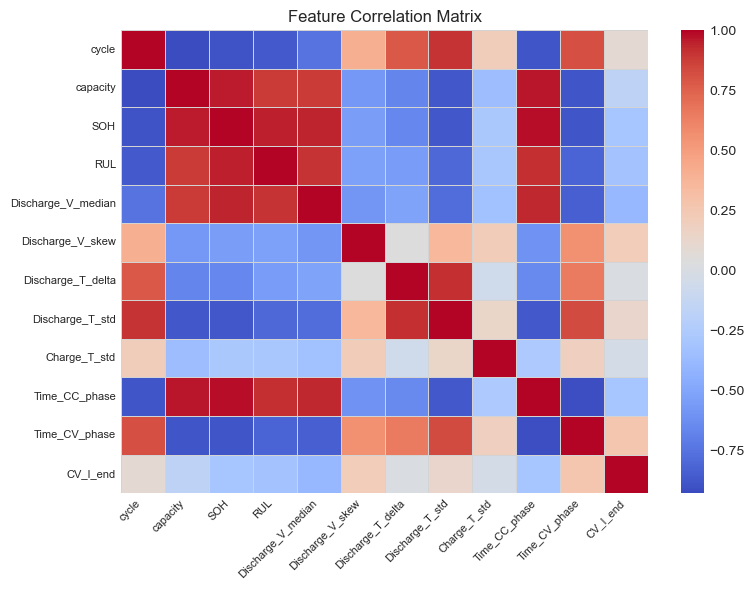

In [11]:
# Init object analyzer
analyzer = FeatureAnalyzer(combined_data=df_scaled)

# Plot heatmap
analyzer.plot_correlation_heatmap(figsize=(8, 6), annot=False)


Top 5 Positive/Negative:
SOH                   0.948663
Time_CC_phase         0.912891
Discharge_V_median    0.904691
capacity              0.880138
Charge_T_std         -0.288949
Name: RUL, dtype: float64
Discharge_V_skew    -0.532074
Discharge_T_delta   -0.559170
Discharge_T_std     -0.802010
Time_CV_phase       -0.820488
cycle               -0.866456
Name: RUL, dtype: float64

Plotting correlation with target: 'RUL'...


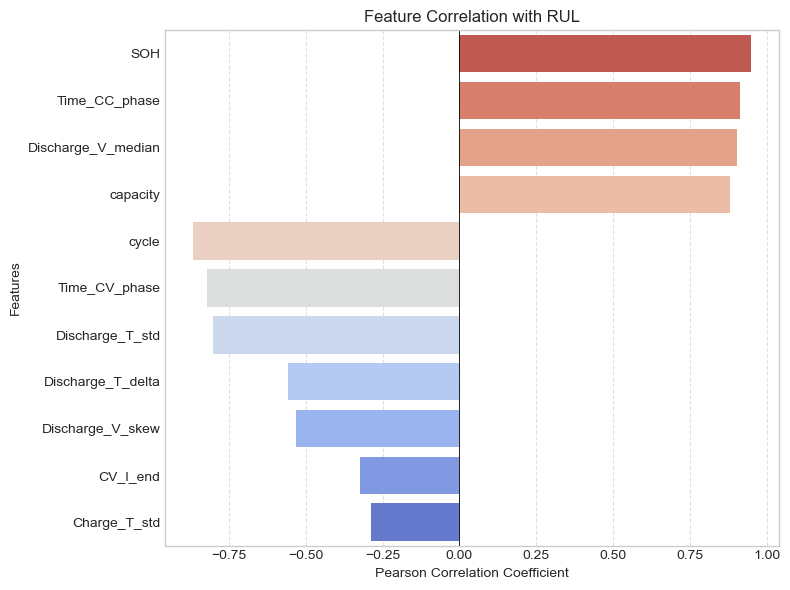

In [12]:
# Get correlation value with SOH and RUL
soh_correlation = analyzer.get_correlation_with_target('RUL')

print("Top 5 Positive/Negative:")
print(soh_correlation.drop('RUL', errors='ignore').head())
print(soh_correlation.drop('RUL', errors='ignore').tail())
analyzer.plot_correlation_with_target('RUL', sort_by_abs=True, figsize=(8,6))


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    LeaveOneGroupOut, GridSearchCV, GroupKFold, KFold, train_test_split
)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C_kernel, WhiteKernel
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
import matplotlib.pyplot as plt
import warnings
import time

warnings.filterwarnings('ignore')

# RANDOM FOREST

In [14]:
param_groups = [
    {
        'name': 'Group 1: Baseline (Default-ish)',
        'params': {
            'n_estimators': 100,
            'max_depth': None, # Cho phép cây phát triển đầy đủ
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt', # Mặc định cho hồi quy
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 2: More Trees',
        'params': {
            'n_estimators': 300, # Tăng số cây
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 3: Introduce Regularization (Mild)',
        'params': {
            'n_estimators': 300,
            'max_depth': 20, # Giới hạn độ sâu cây
            'min_samples_split': 5, # Yêu cầu nhiều mẫu hơn để tách
            'min_samples_leaf': 2, # Yêu cầu nhiều mẫu hơn ở nút lá
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 4: More Trees & Stronger Regularization',
        'params': {
            'n_estimators': 500, # Tăng thêm số cây
            'max_depth': 15, # Giới hạn độ sâu chặt hơn một chút
            'min_samples_split': 10, # Yêu cầu nhiều mẫu hơn để tách
            'min_samples_leaf': 3, # Yêu cầu nhiều mẫu hơn ở nút lá
            'max_features': 0.8, # Thử sử dụng 80% đặc trưng
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 5: High N_estimators & Fine-tuned',
        'params': {
            'n_estimators': 700, # Rất nhiều cây
            'max_depth': 25, # Cho phép cây sâu hơn một chút
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 0.7, # Điều chỉnh số lượng đặc trưng
            'random_state': 42,
            'n_jobs': -1
        }
    }
]

# NOT USE LOBO, split data training/testing (3/1)

In [15]:
df_B0005 = df_scaled[df_scaled['battery_id'] == 'B0005'].copy()
df_B0006 = df_scaled[df_scaled['battery_id'] == 'B0006'].copy()
df_B0007 = df_scaled[df_scaled['battery_id'] == 'B0007'].copy()
df_B0018 = df_scaled[df_scaled['battery_id'] == 'B0018'].copy()

battery_dataframes = [df_B0005, df_B0006, df_B0007, df_B0018]

target_column = 'RUL'
group_column = 'battery_id'
cycle_plot_column = 'cycle'

feature_columns= ['Discharge_V_median','Time_CC_phase', 'Time_CV_phase','Discharge_T_delta', 'SOH']
battery_ids_for_plotting = ['B0005', 'B0006', 'B0007', 'B0018']


In [16]:
result_rf = []

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.10 giây
  R-squared for B0005: 0.9911
  MAE for B0005: 3.0257
  RMSE for B0005: 4.5759


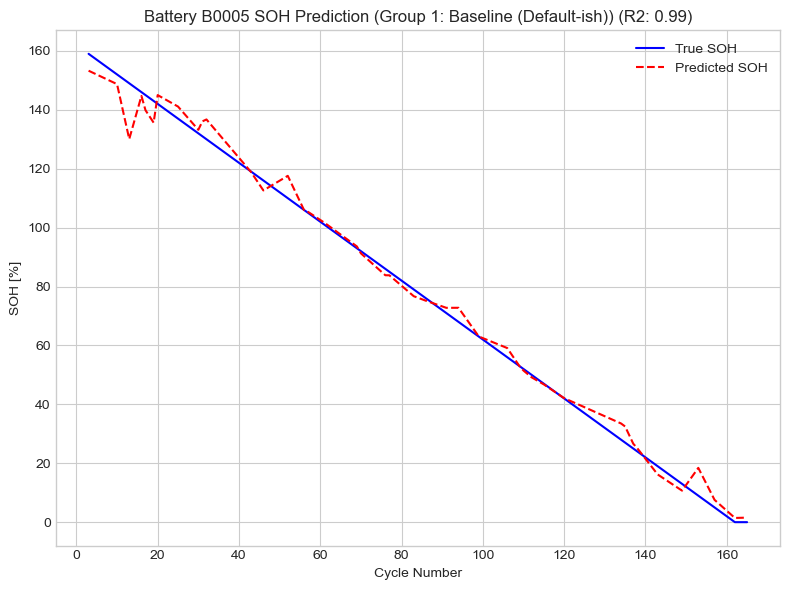


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.24 giây
  R-squared for B0005: 0.9916
  MAE for B0005: 3.1137
  RMSE for B0005: 4.4518


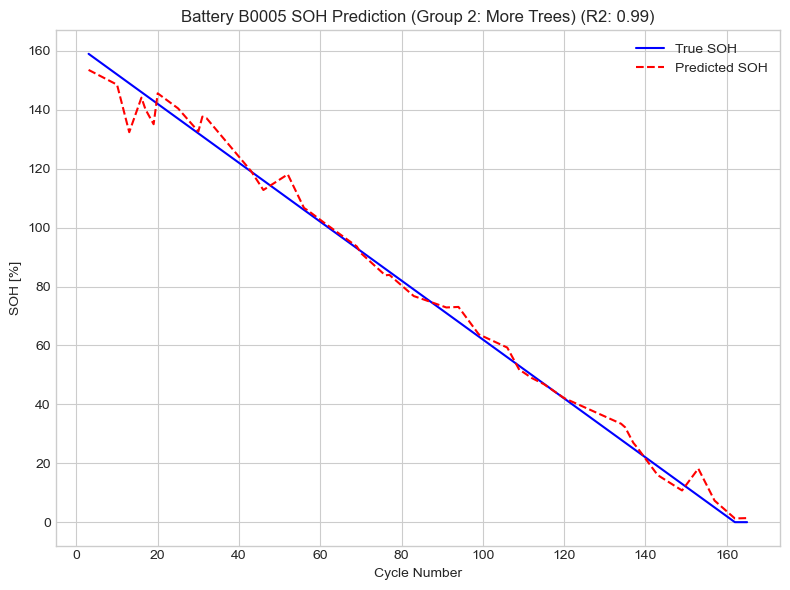


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
  R-squared for B0005: 0.9909
  MAE for B0005: 3.2466
  RMSE for B0005: 4.6186


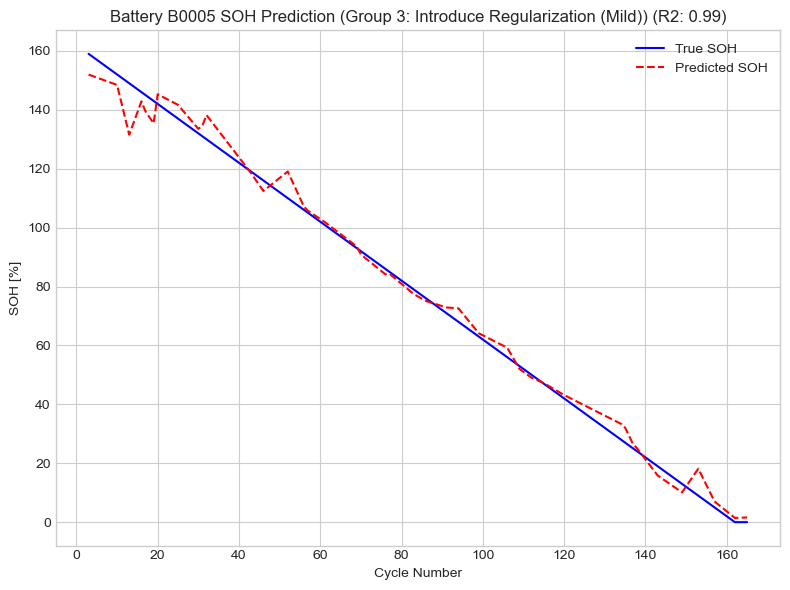


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.37 giây
  R-squared for B0005: 0.9881
  MAE for B0005: 3.7223
  RMSE for B0005: 5.2942


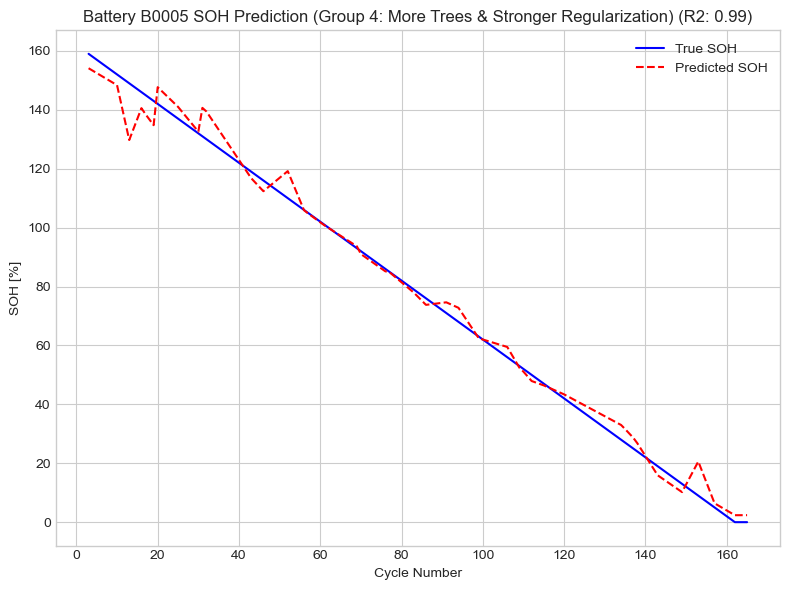


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.55 giây
  R-squared for B0005: 0.9904
  MAE for B0005: 3.2220
  RMSE for B0005: 4.7563


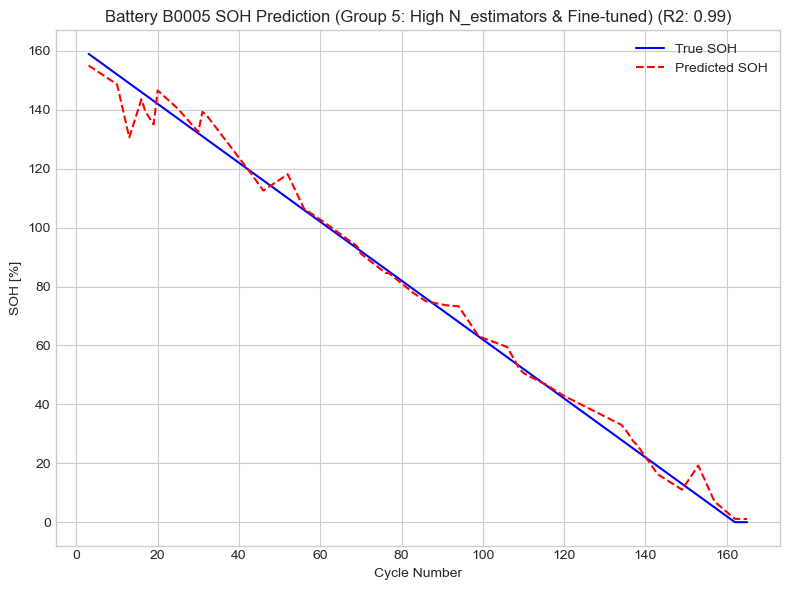


--- Đánh giá trên tất cả các nhóm tham số cho pin B0005 hoàn tất ---


In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Trích xuất X và Y cho pin B0005
X_B0005 = df_B0005[feature_columns]
y_B0005 = df_B0005[target_column]
cycles_B0005 = df_B0005[cycle_plot_column] # Để vẽ đồ thị
metrics_validate_B0005 = []

print(f"Tổng số mẫu cho pin B0005: {len(df_B0005)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0005, y_B0005, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    # Đo thời gian huấn luyện mô hình
    start_time = time.time()

    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    metrics_validate_B0005.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    print(f"  R-squared for B0005: {battery_r2:.4f}")
    print(f"  MAE for B0005: {battery_mae:.4f}")
    print(f"  RMSE for B0005: {battery_rmse:.4f}")

    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0005.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0005 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ

print("\n--- Đánh giá trên tất cả các nhóm tham số cho pin B0005 hoàn tất ---")


Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.09 giây
  R-squared for B0005: 0.9915
  MAE for B0005: 2.0467
  RMSE for B0005: 3.1757


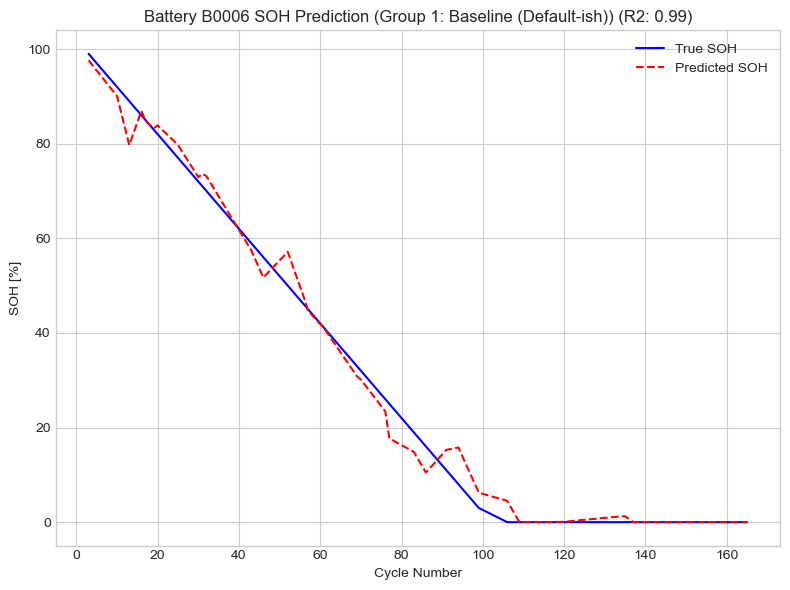


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
  R-squared for B0005: 0.9916
  MAE for B0005: 2.0083
  RMSE for B0005: 3.1520


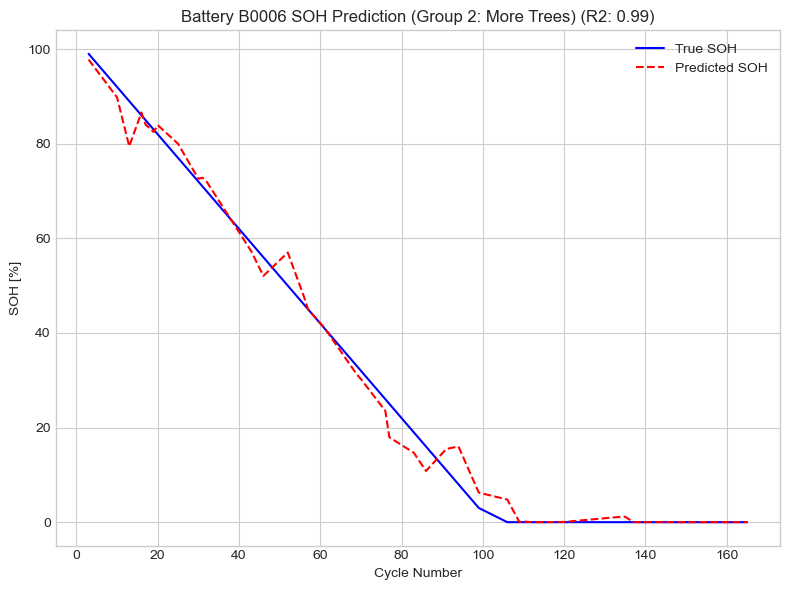


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.26 giây
  R-squared for B0005: 0.9904
  MAE for B0005: 2.1901
  RMSE for B0005: 3.3698


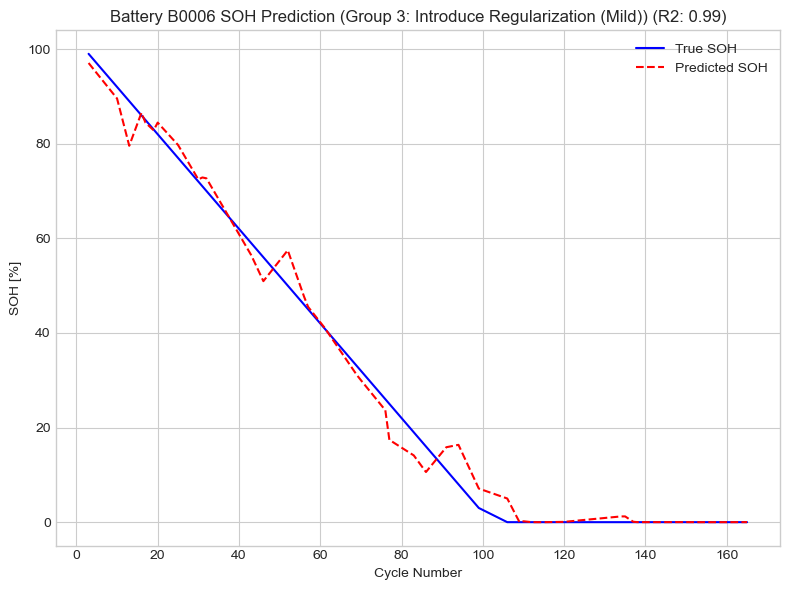


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.40 giây
  R-squared for B0005: 0.9890
  MAE for B0005: 2.4089
  RMSE for B0005: 3.6004


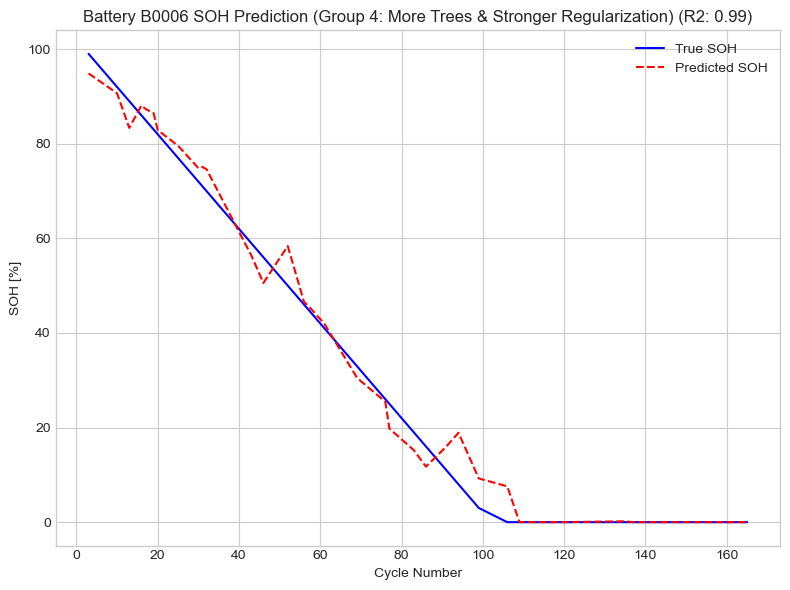


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.56 giây
  R-squared for B0005: 0.9915
  MAE for B0005: 2.0262
  RMSE for B0005: 3.1720


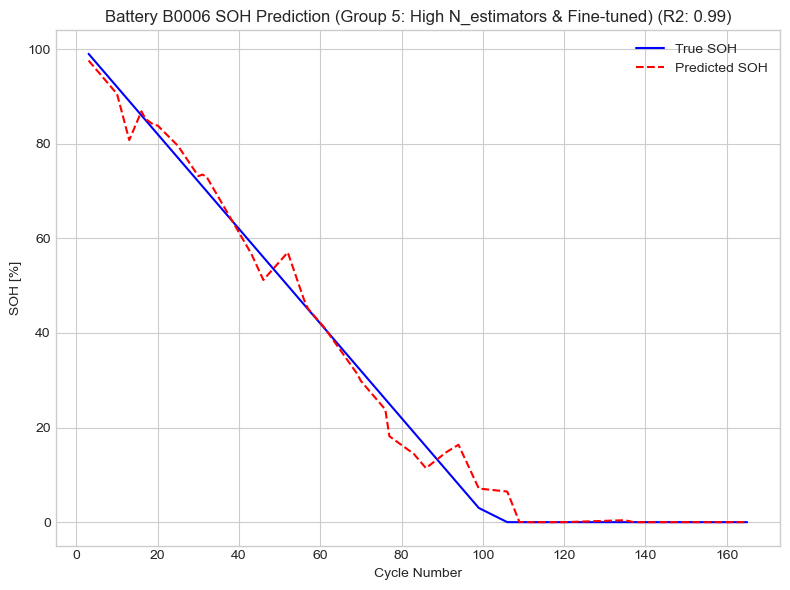

In [23]:
# Trích xuất X và Y cho pin B0005
X_B0006 = df_B0006[feature_columns]
y_B0006 = df_B0006[target_column]
cycles_B0006 = df_B0006[cycle_plot_column] # Để vẽ đồ thị


print(f"Tổng số mẫu cho pin B0005: {len(df_B0006)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---")
metrics_validate_B0006 = []
# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0006, y_B0006, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0005: {battery_r2:.4f}")
    print(f"  MAE for B0005: {battery_mae:.4f}")
    print(f"  RMSE for B0005: {battery_rmse:.4f}")
    metrics_validate_B0006.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0006.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0006 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ


Tổng số mẫu cho pin B0007: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0007 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.09 giây
  R-squared for B0007: 0.9871
  MAE for B0007: 3.7243
  RMSE for B0007: 5.5172


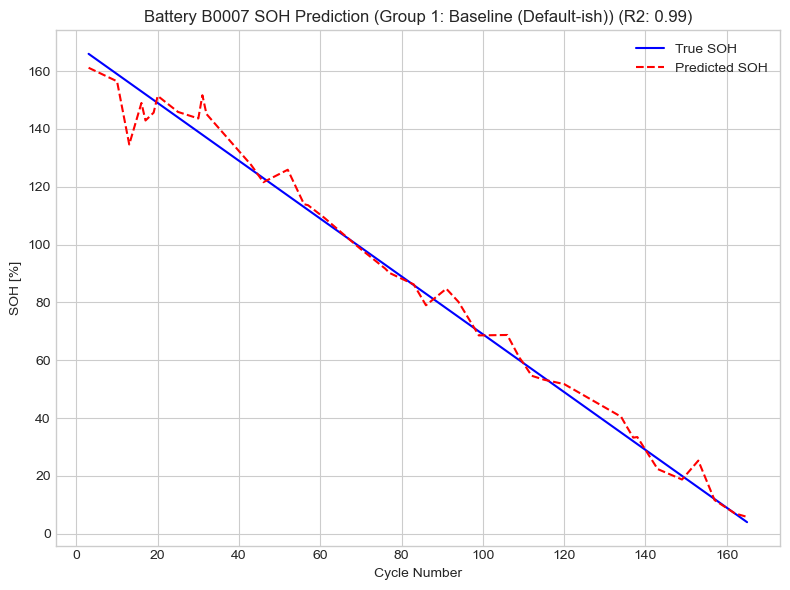


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.24 giây
  R-squared for B0007: 0.9884
  MAE for B0007: 3.5590
  RMSE for B0007: 5.2466


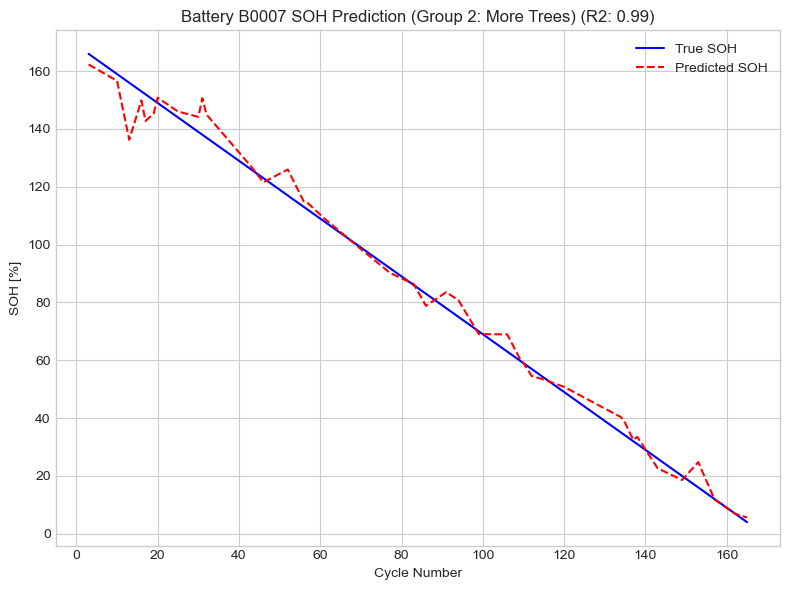


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.26 giây
  R-squared for B0007: 0.9872
  MAE for B0007: 3.7304
  RMSE for B0007: 5.5028


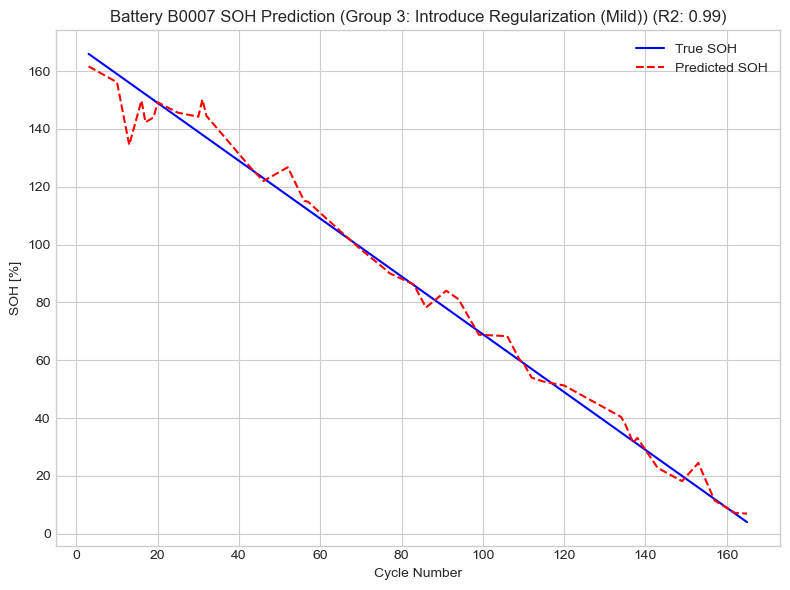


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.40 giây
  R-squared for B0007: 0.9860
  MAE for B0007: 3.8930
  RMSE for B0007: 5.7531


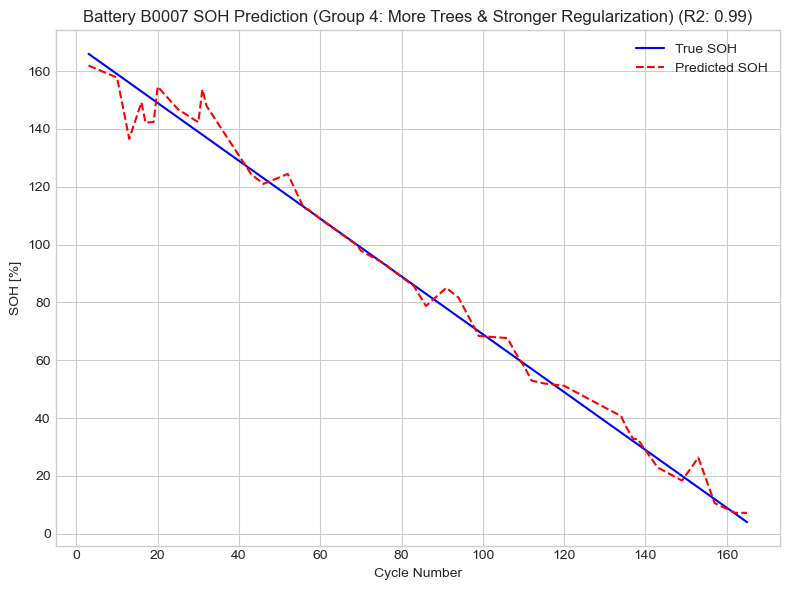


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.75 giây
  R-squared for B0007: 0.9868
  MAE for B0007: 3.6064
  RMSE for B0007: 5.5945


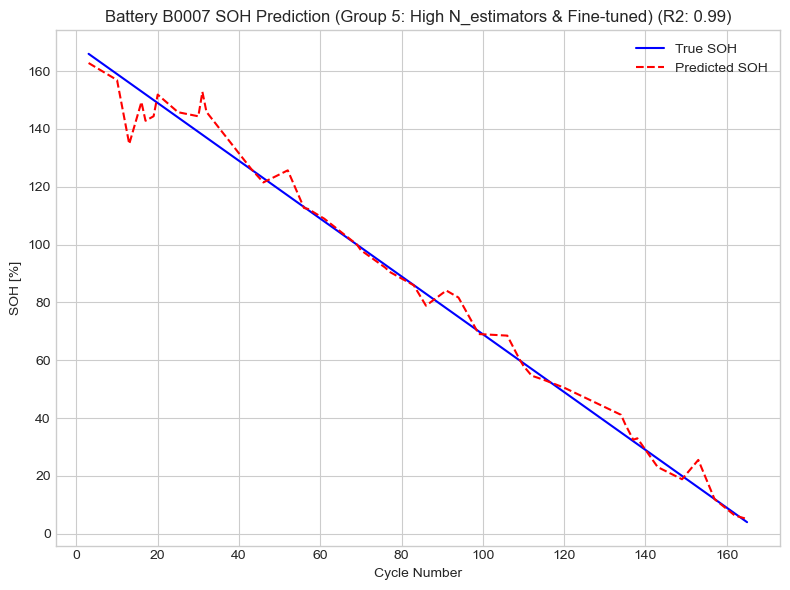

In [24]:
# Trích xuất X và Y cho pin B0005
X_B0007 = df_B0007[feature_columns]
y_B0007 = df_B0007[target_column]
cycles_B0007 = df_B0007[cycle_plot_column] # Để vẽ đồ thị


print(f"Tổng số mẫu cho pin B0007: {len(df_B0007)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0007 (chia ngẫu nhiên 75:25) ---")
metrics_validate_B0007 = []
# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0007, y_B0007, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0007: {battery_r2:.4f}")
    print(f"  MAE for B0007: {battery_mae:.4f}")
    print(f"  RMSE for B0007: {battery_rmse:.4f}")
    metrics_validate_B0007.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0007.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0007 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ


Tổng số mẫu cho pin B0018: 132 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.09 giây
[ 91.07  47.06 109.91  99.36  55.33  16.95  91.91  19.07  67.38 103.13
  76.35 104.82  96.8  126.1   32.07  21.94  92.02  50.08  95.26  74.69
 111.1  125.71  90.66 124.88  41.38  65.75  14.37  28.78  27.32 121.98
 121.23   9.4   64.15]
560     76
587     49
523    113
535    101
580     56
621     15
559     77
632      4
568     68
530    106
548     88
531    105
551     85
508    128
602     34
605     31
540     96
585

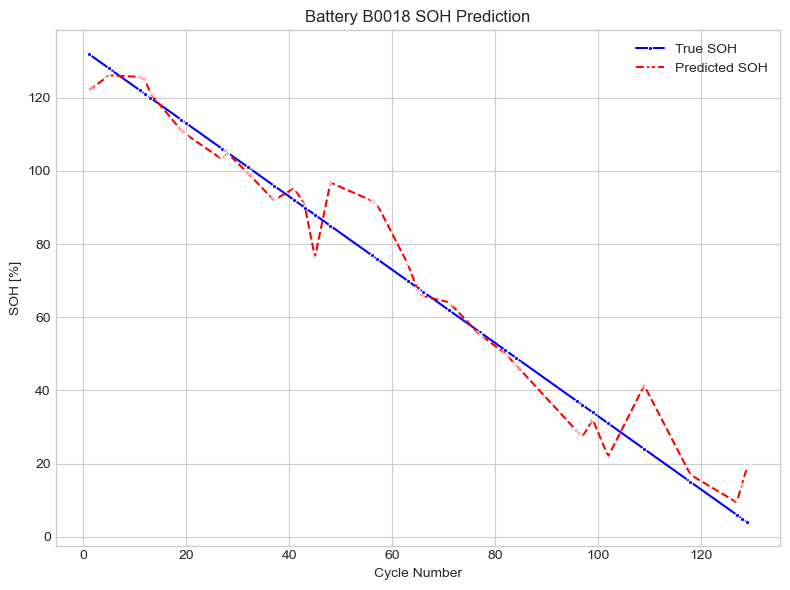


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.25 giây
[ 91.56333333  47.04666667 109.75        99.39666667  55.80666667
  17.07333333  91.65666667  20.51333333  67.72666667 104.73666667
  76.05333333 105.39666667  95.08333333 125.80333333  32.67666667
  21.82666667  92.33        50.17666667  94.83666667  74.14666667
 110.56666667 125.61        90.69       124.47666667  41.22666667
  66.64666667  14.81        29.14        26.96333333 121.70333333
 120.76        10.16        64.40333333]
560     76
587     49
523    113
535    101
580     56
621     15
559     77
632      4
568     68
530    106
548     88
531    105
551     85
508    128
602     34
605     31
540     96
585     51
544     92
566     70
522    114
5

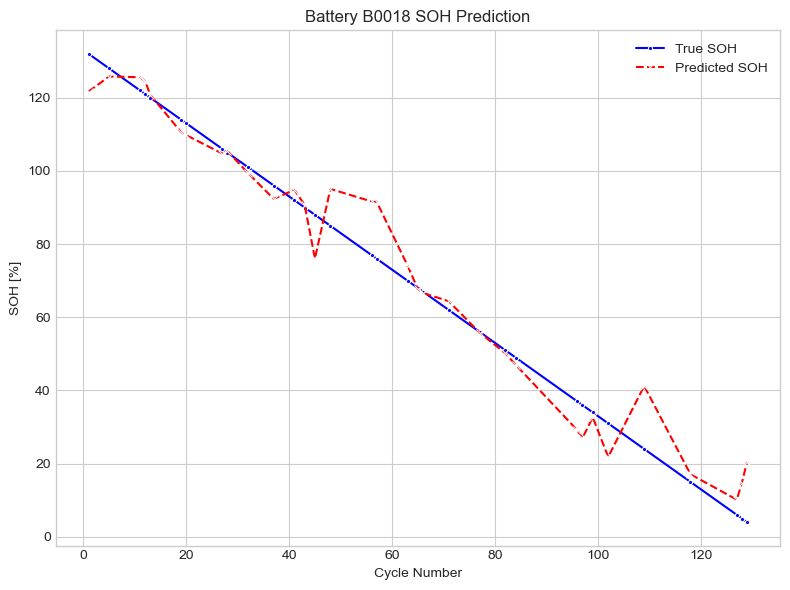


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.27 giây
[ 92.73628571  47.16034392 108.95229762  98.7213082   56.02479894
  16.97321489  91.47359728  19.37689947  68.26021296 104.28725794
  74.81415957 104.29124735  96.4212672  125.52718519  31.97031674
  21.3935873   92.19294781  49.83006349  94.17847884  75.32399471
 110.16965212 125.27815476  89.35302321 124.85295238  41.57233874
  67.12370635  13.83676515  28.25787915  25.11579317 121.26261508
 121.32006217  11.29008129  64.63006878]
560     76
587     49
523    113
535    101
580     56
621     15
559     77
632      4
568     68
530    106
548     88
531    105
551     85
508    128
602     34
605     31
540     96
585     51
544     92
566 

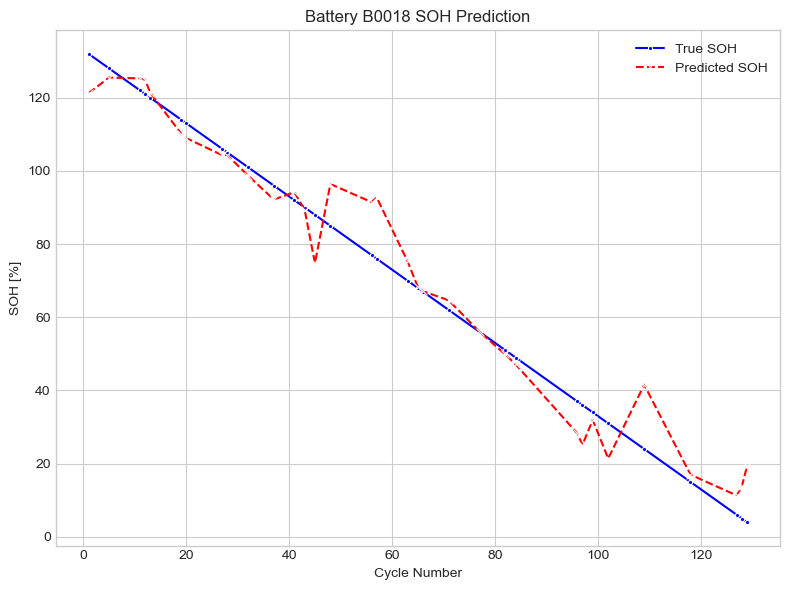


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.39 giây
[ 92.65473814  49.10993317 110.99439099  98.11769337  56.34069283
  13.01122862  92.17465895  20.66203813  68.03261865 107.53145258
  75.5413553  106.88589668  94.59360025 124.52505874  34.75893214
  17.25510984  92.43699435  51.7150683   93.13944107  75.76997462
 112.6585616  124.55341986  90.74175414 124.64411265  38.33156424
  66.34638925  10.99811445  27.54675817  25.75934776 121.87697477
 120.25404159  10.93906572  63.92624676]
560     76
587     49
523    113
535    101
580     56
621     15
559     77
632      4
568     68
530    106
548     88
531    105
551     85
508    128
602     34
605     31
540     96
585     51
544     92
5

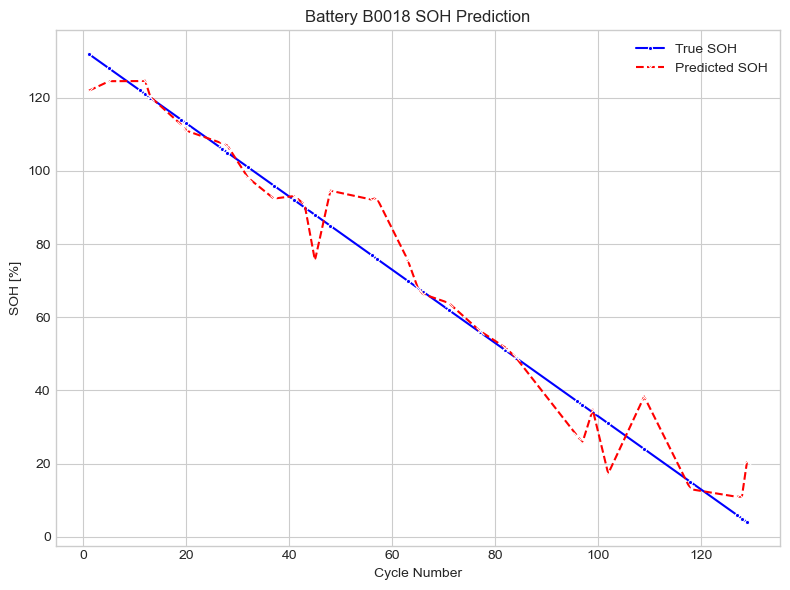


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.54 giây
[ 92.65628743  48.31789094 108.8737985   99.27881035  56.30153118
  15.47569218  92.63318651  19.17117764  68.39104623 104.77462389
  74.54242187 104.48521434  94.42427293 126.23194218  34.72239332
  20.41002077  92.55424546  50.96661704  94.72849027  74.15168342
 109.87996599 125.7003581   90.35407029 126.25072828  38.70867218
  66.9124126   12.22729195  29.32030416  26.52540182 124.56427721
 121.06957017  10.05282777  65.12589683]
560     76
587     49
523    113
535    101
580     56
621     15
559     77
632      4
568     68
530    106
548     88
531    105
551     85
508    128
602     34
605     31
540     96
585     51
544     92
566     

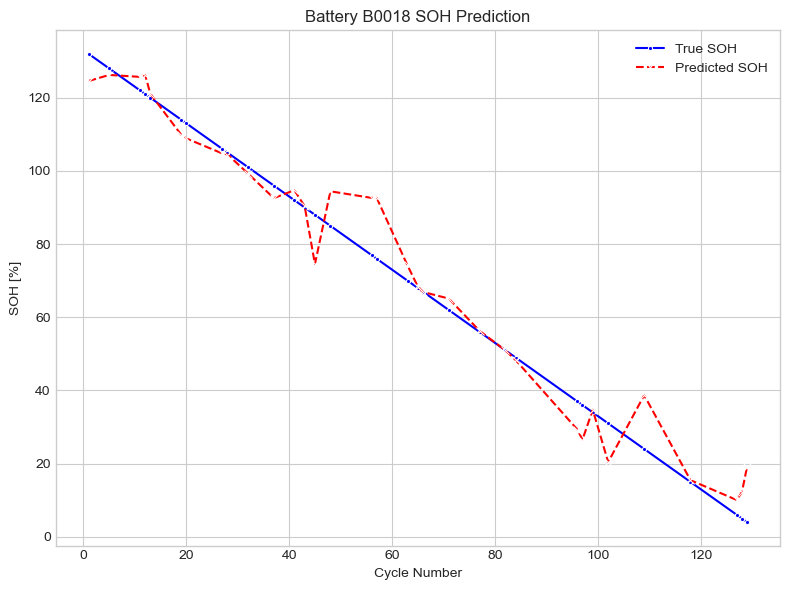

In [25]:
# Trích xuất X và Y cho pin B0005
X_B0018 = df_B0018[feature_columns]
y_B0018 = df_B0018[target_column]
cycles_B0018 = df_B0018[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_B0018 = []
print(f"Tổng số mẫu cho pin B0018: {len(df_B0018)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0018, y_B0018, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)
    print(y_pred)
    print(y_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0018: {battery_r2:.4f}")
    print(f"  MAE for B0018: {battery_mae:.4f}")
    print(f"  RMSE for B0018: {battery_rmse:.4f}")
    metrics_validate_B0018.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0018.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax, marker='.', markersize=6)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=6)
    
    ax.set_title(f'Battery B0018 SOH Prediction')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ


In [21]:
for i in range(5):
    print(f'Mean R-square group {i + 1}: ', (metrics_validate_B0018[i]['r2'] + metrics_validate_B0005[i]['r2'] + metrics_validate_B0006[i]['r2'] + metrics_validate_B0007[i]['r2']) / 4)
    print(f'Mean MAE group {i + 1}: ', (metrics_validate_B0005[i]['mae'] + metrics_validate_B0006[i]['mae'] + metrics_validate_B0007[i]['mae'] + metrics_validate_B0018[i]['mae']) / 4)
    print(f'Mean RMSE group {i + 1}: ', (metrics_validate_B0005[i]['rmse'] + metrics_validate_B0006[i]['rmse'] + metrics_validate_B0007[i]['rmse'] + metrics_validate_B0018[i]['rmse']) / 4)


Mean R-square group 1:  0.9830530183331044
Mean MAE group 1:  3.5631818181818184
Mean RMSE group 1:  5.1682723505625185
Mean R-square group 2:  0.9833988670649474
Mean MAE group 2:  3.511576479076479
Mean RMSE group 2:  5.07478743076928
Mean R-square group 3:  0.9818298788016648
Mean MAE group 3:  3.7188410929498597
Mean RMSE group 3:  5.313499911613608
Mean R-square group 4:  0.9809750998458717
Mean MAE group 4:  3.84461144202713
Mean RMSE group 4:  5.555402904407282
Mean R-square group 5:  0.9830675568696856
Mean MAE group 5:  3.512934769084926
Mean RMSE group 5:  5.203995719587068


In [26]:
print(type(result_rf[0]))

<class 'pandas.core.frame.DataFrame'>


In [30]:
result_rf[3].to_csv('./result/rul_split/rul_rf_b0018.csv')

# XGBoosting

In [31]:
# --- Định nghĩa 5 nhóm tham số cho XGBoost ---
param_groups_xgb = [
    {
        'name': 'Group 1: XGBoost Baseline (Defaults)',
        'params': {
            'n_estimators': 100,      # Số lượng cây (boosting rounds)
            'learning_rate': 0.1,     # Tốc độ học
            'max_depth': 3,           # Độ sâu tối đa của mỗi cây
            'subsample': 1.0,         # Tỷ lệ mẫu được lấy mẫu ngẫu nhiên cho mỗi cây
            'colsample_bytree': 1.0,  # Tỷ lệ đặc trưng được lấy mẫu ngẫu nhiên cho mỗi cây
            'gamma': 0,               # Mức giảm loss tối thiểu để thực hiện chia nút
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 2: More Estimators, Slightly Deeper Trees',
        'params': {
            'n_estimators': 300,
            'learning_rate': 0.1,
            'max_depth': 5,          # Tăng độ sâu cây
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'gamma': 0,
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 3: Slower Learning, More Trees, Subsampling',
        'params': {
            'n_estimators': 500,
            'learning_rate': 0.05,   # Giảm tốc độ học
            'max_depth': 6,
            'subsample': 0.7,        # Bắt đầu lấy mẫu hàng
            'colsample_bytree': 0.7, # Bắt đầu lấy mẫu cột
            'gamma': 0,
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 4: Stronger Regularization, More Trees',
        'params': {
            'n_estimators': 800,
            'learning_rate': 0.02,   # Học chậm hơn nữa
            'max_depth': 7,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,            # Giới thiệu gamma
            'reg_alpha': 0.005,      # Giới thiệu L1 regularization
            'reg_lambda': 0.5,       # Điều chỉnh L2 regularization
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 5: Very High Estimators & Fine-tuned',
        'params': {
            'n_estimators': 1200,    # Rất nhiều cây
            'learning_rate': 0.01,   # Rất chậm
            'max_depth': 8,          # Cho phép cây sâu hơn chút
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'gamma': 0.2,
            'reg_alpha': 0.01,
            'reg_lambda': 1.0,       # Đặt lại L2 mặc định hoặc điều chỉnh
            'random_state': 42,
            'n_jobs': -1
        }
    }
]


In [37]:
result_xgb = []

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.04 giây
  R-squared for B0005: 0.9848
  MAE for B0005: 4.1317
  RMSE for B0005: 5.9787


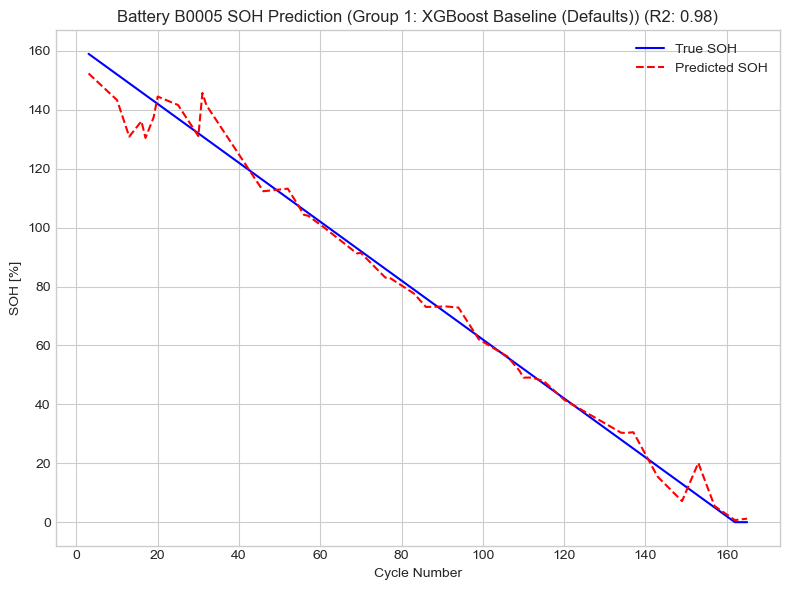


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.12 giây
  R-squared for B0005: 0.9815
  MAE for B0005: 4.3243
  RMSE for B0005: 6.5925


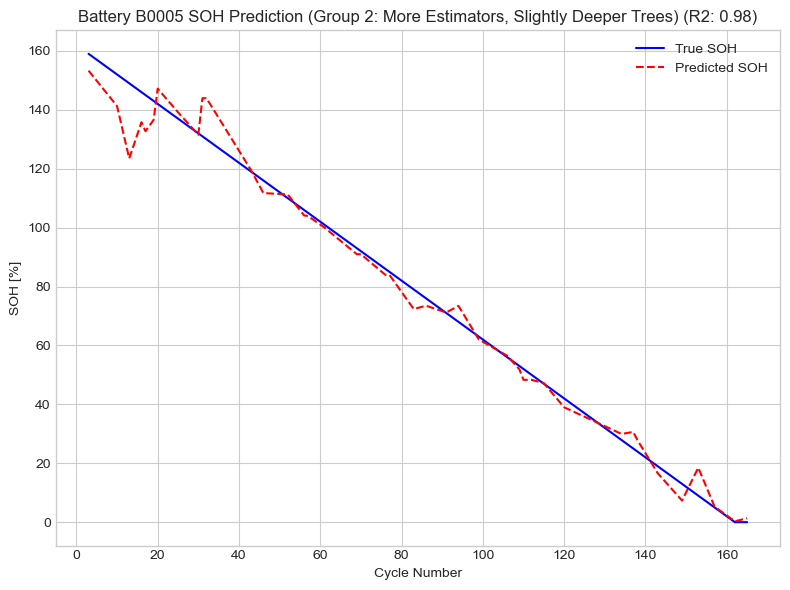


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.21 giây
  R-squared for B0005: 0.9849
  MAE for B0005: 4.0950
  RMSE for B0005: 5.9602


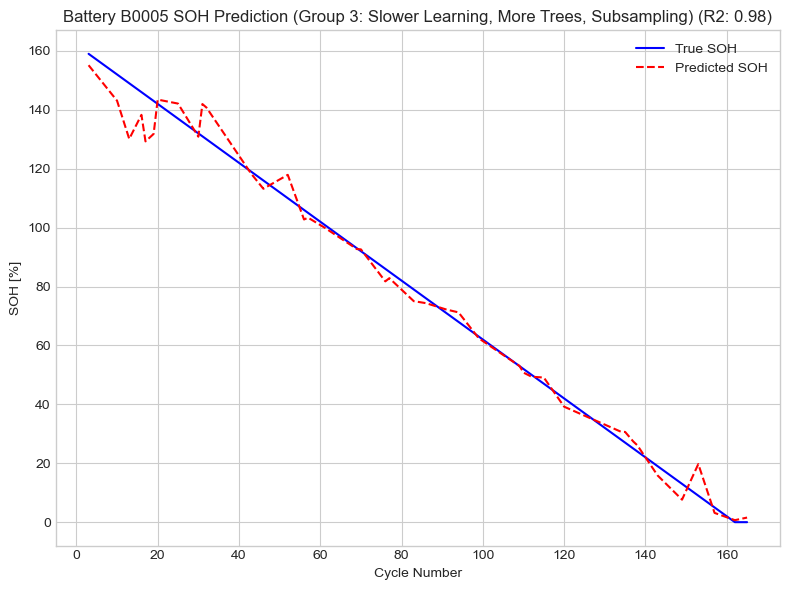


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.23 giây
  R-squared for B0005: 0.9853
  MAE for B0005: 4.0290
  RMSE for B0005: 5.8829


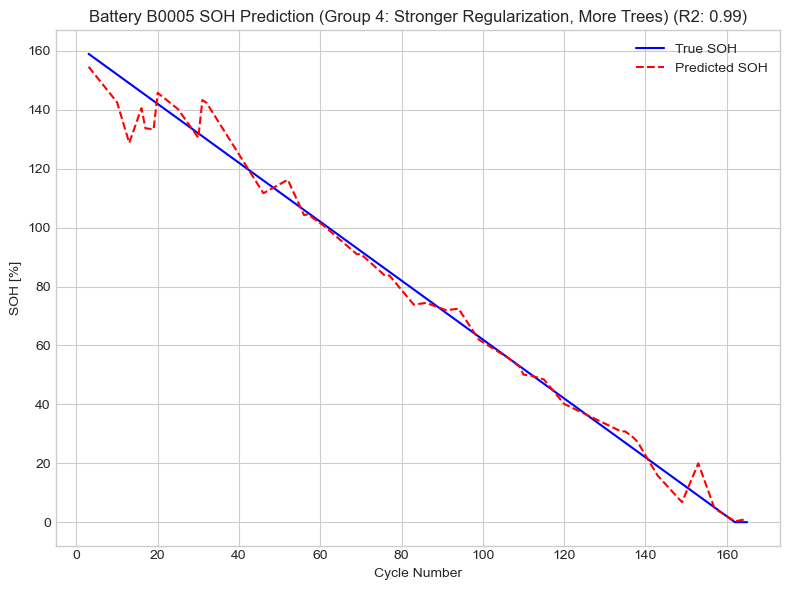


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.33 giây
  R-squared for B0005: 0.9839
  MAE for B0005: 4.1674
  RMSE for B0005: 6.1524


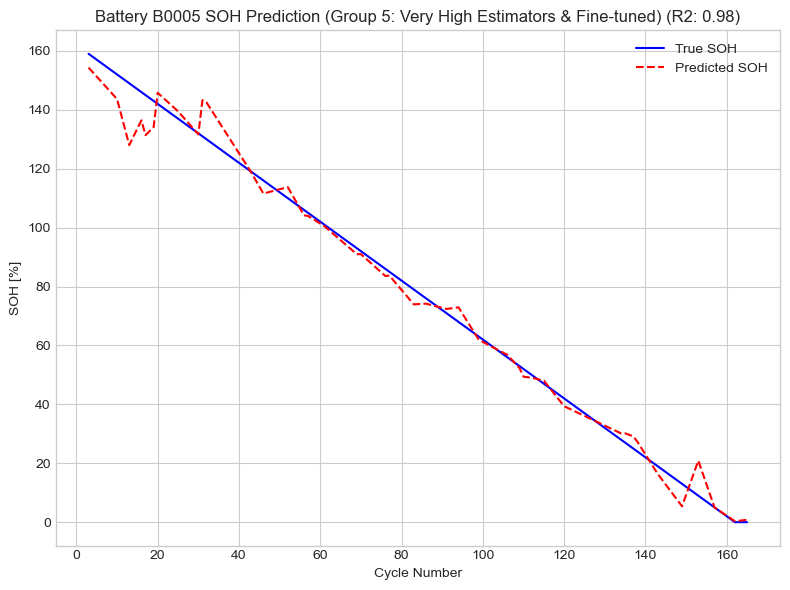

In [38]:
# Trích xuất X và Y cho pin B0005
X_B0005 = df_B0005[feature_columns]
y_B0005 = df_B0005[target_column]
cycles_B0005 = df_B0005[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0005 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0005)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0005, y_B0005, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0005: {battery_r2:.4f}")
    print(f"  MAE for B0005: {battery_mae:.4f}")
    print(f"  RMSE for B0005: {battery_rmse:.4f}")
    metrics_validate_xgb_B0005.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0005.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0005 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.03 giây
R-squared for B0006: 0.9893
MAE for B0006: 2.1859
RMSE for B0006: 3.5522


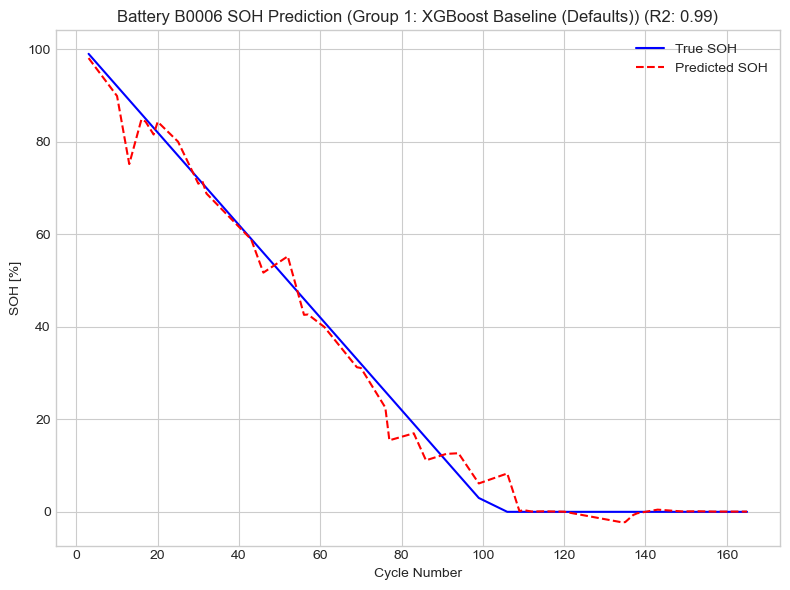


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.10 giây
R-squared for B0006: 0.9873
MAE for B0006: 2.0302
RMSE for B0006: 3.8642


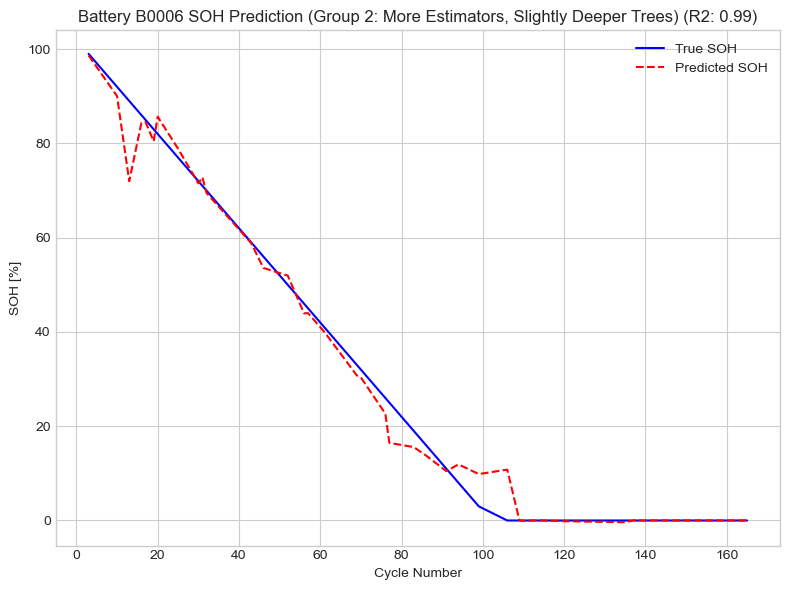


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.18 giây
R-squared for B0006: 0.9920
MAE for B0006: 1.8177
RMSE for B0006: 3.0820


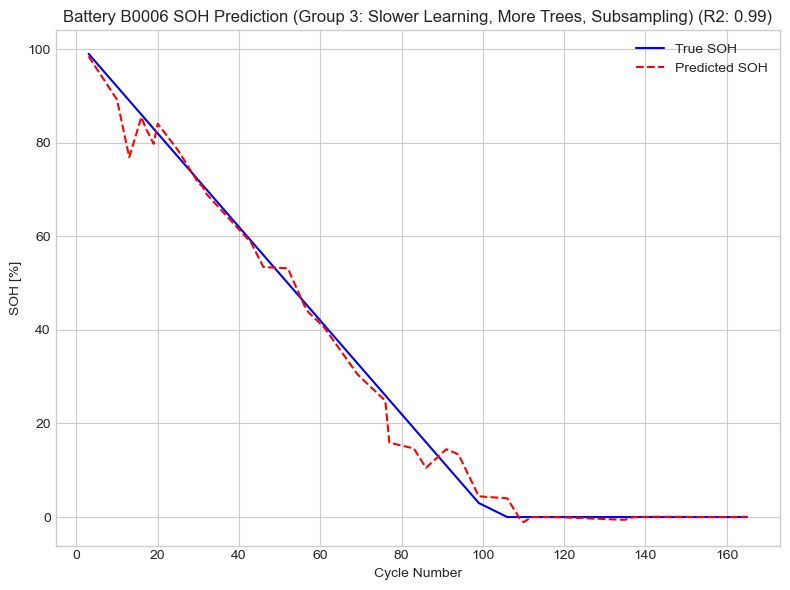


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.18 giây
R-squared for B0006: 0.9926
MAE for B0006: 1.8257
RMSE for B0006: 2.9552


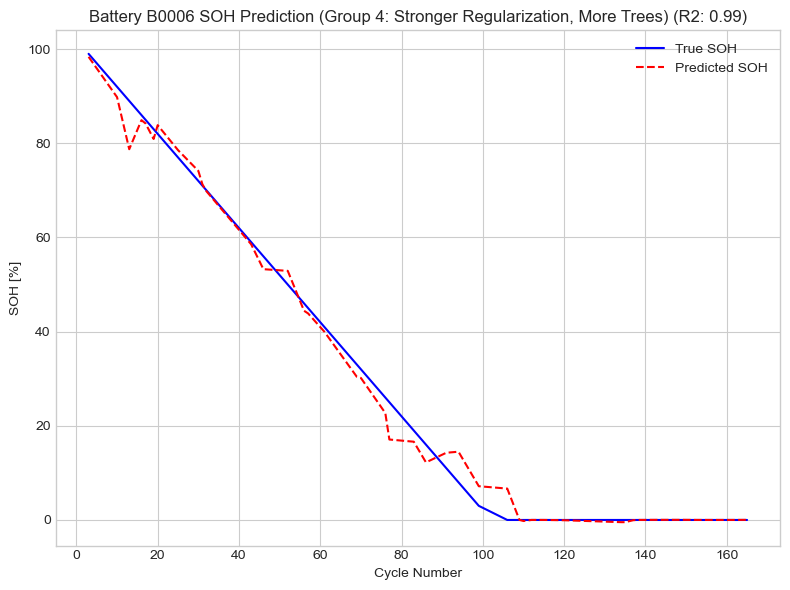


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.30 giây
R-squared for B0006: 0.9914
MAE for B0006: 1.9081
RMSE for B0006: 3.1778


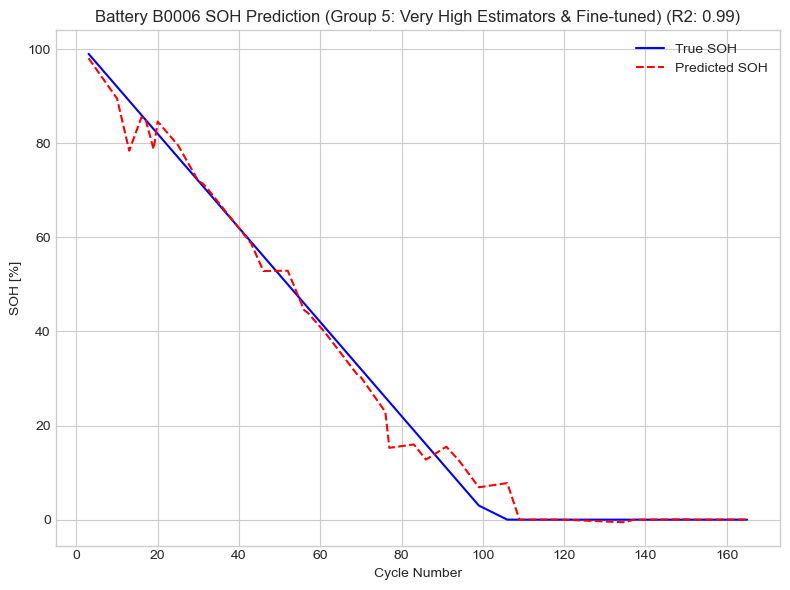

In [39]:
# Trích xuất X và Y cho pin B0006
X_B0006 = df_B0006[feature_columns]
y_B0006 = df_B0006[target_column]
cycles_B0006 = df_B0006[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0006 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0006)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0006, y_B0006, test_size=0.25, random_state=42
    )
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R-squared for B0006: {battery_r2:.4f}")
    print(f"MAE for B0006: {battery_mae:.4f}")
    print(f"RMSE for B0006: {battery_rmse:.4f}")
    metrics_validate_xgb_B0006.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    test_cycle_data_for_plot = cycles_B0006.loc[y_test.index].sort_values()
    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--') 
    ax.set_title(f'Battery B0006 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True) 
    plt.tight_layout()
    plt.show() 
    plt.close(fig)

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.03 giây
R-squared for B0007: 0.9826
MAE for B0007: 4.1807
RMSE for B0007: 6.4112


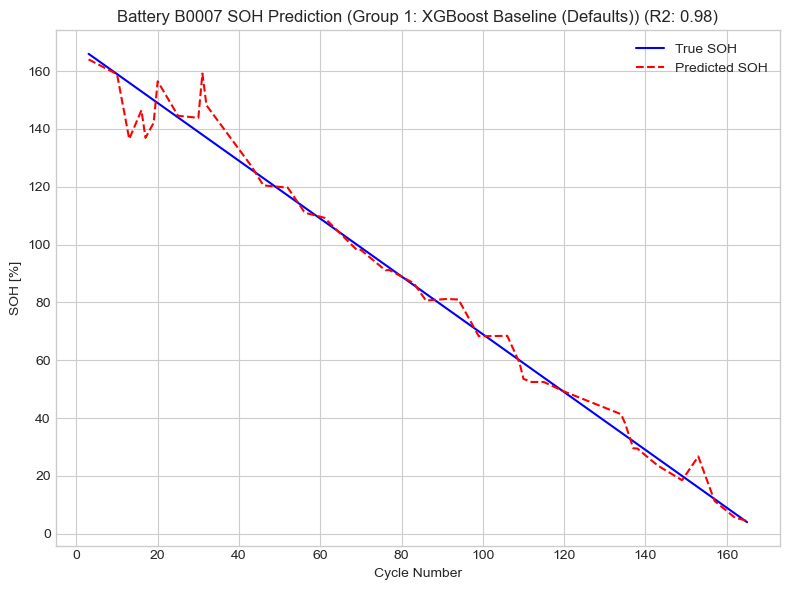


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.11 giây
R-squared for B0007: 0.9836
MAE for B0007: 4.0925
RMSE for B0007: 6.2364


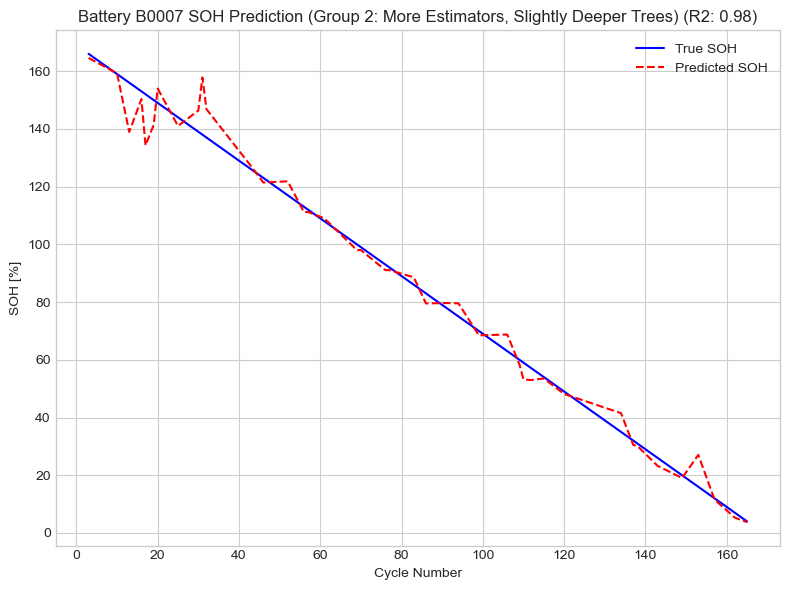


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.20 giây
R-squared for B0007: 0.9837
MAE for B0007: 3.9880
RMSE for B0007: 6.2059


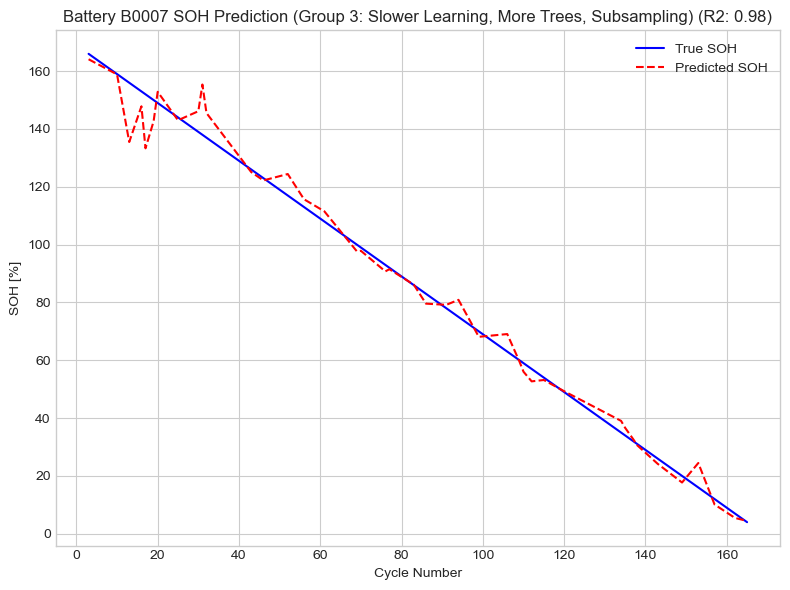


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.21 giây
R-squared for B0007: 0.9819
MAE for B0007: 4.0262
RMSE for B0007: 6.5369


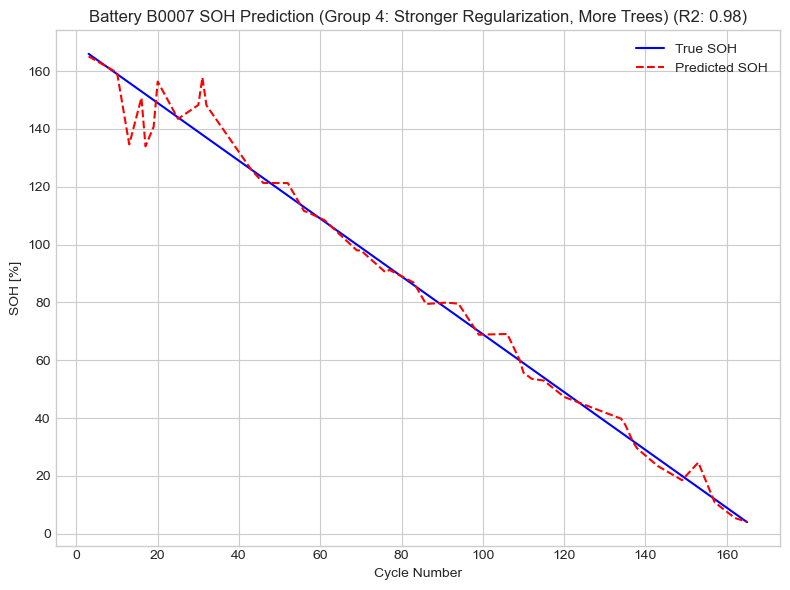


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.35 giây
R-squared for B0007: 0.9808
MAE for B0007: 4.2145
RMSE for B0007: 6.7339


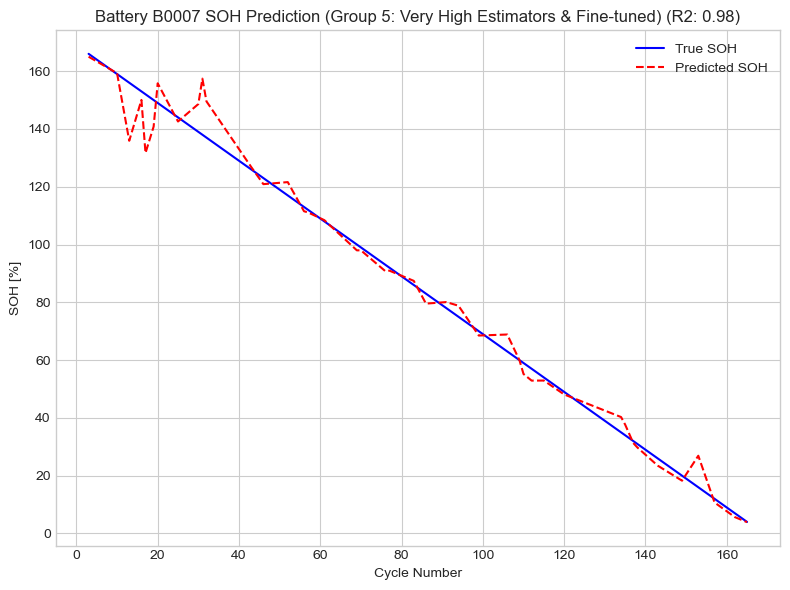

In [40]:
# Trích xuất X và Y cho pin B0007
X_B0007 = df_B0007[feature_columns]
y_B0007 = df_B0007[target_column]
cycles_B0007 = df_B0007[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0007 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0007)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0007, y_B0007, test_size=0.25, random_state=42
    )
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    # Huấn luyện mô hình Random Forest-
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R-squared for B0007: {battery_r2:.4f}")
    print(f"MAE for B0007: {battery_mae:.4f}")
    print(f"RMSE for B0007: {battery_rmse:.4f}")
    metrics_validate_xgb_B0007.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    test_cycle_data_for_plot = cycles_B0007.loc[y_test.index].sort_values()
    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--') 
    ax.set_title(f'Battery B0007 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True) 
    plt.tight_layout()
    plt.show() 
    plt.close(fig)

Tổng số mẫu cho pin B0005: 132 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Time_CC_phase', 'Time_CV_phase', 'Discharge_T_delta', 'SOH']
--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.03 giây
R-squared for B0018: 0.9683
MAE for B0018: 5.3656
RMSE for B0018: 6.8088


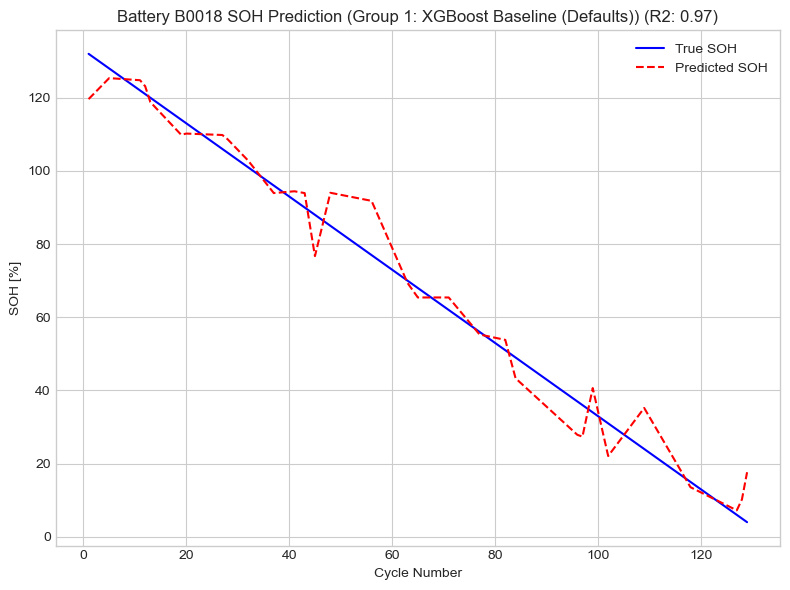


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.11 giây
R-squared for B0018: 0.9649
MAE for B0018: 5.3187
RMSE for B0018: 7.1611


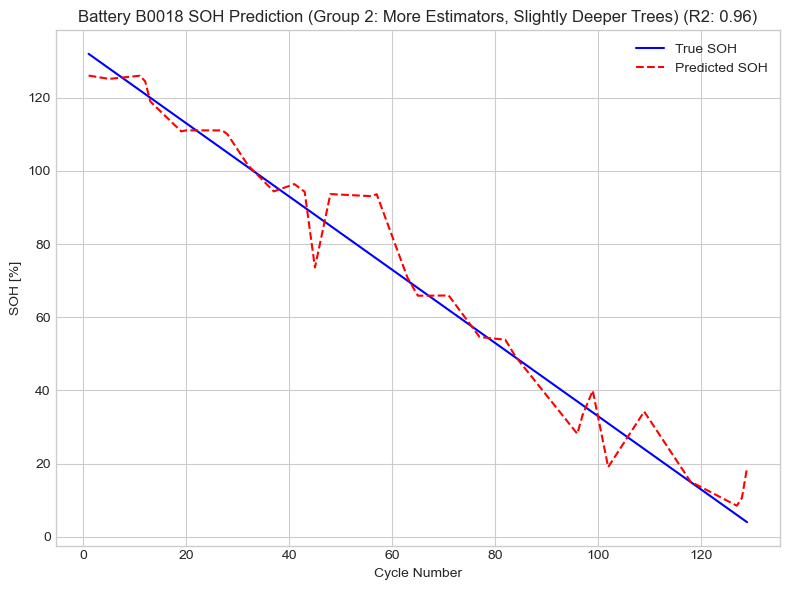


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.18 giây
R-squared for B0018: 0.9692
MAE for B0018: 4.9503
RMSE for B0018: 6.7090


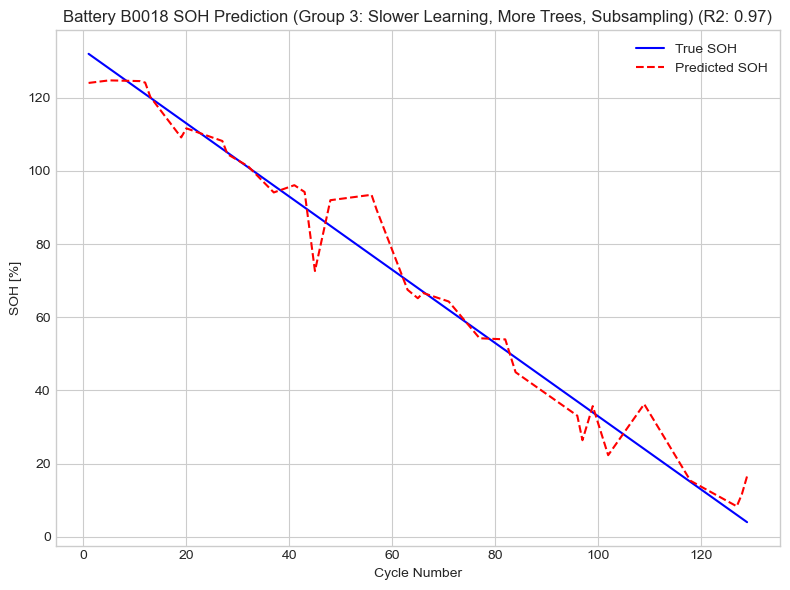


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.19 giây
R-squared for B0018: 0.9689
MAE for B0018: 4.9383
RMSE for B0018: 6.7440


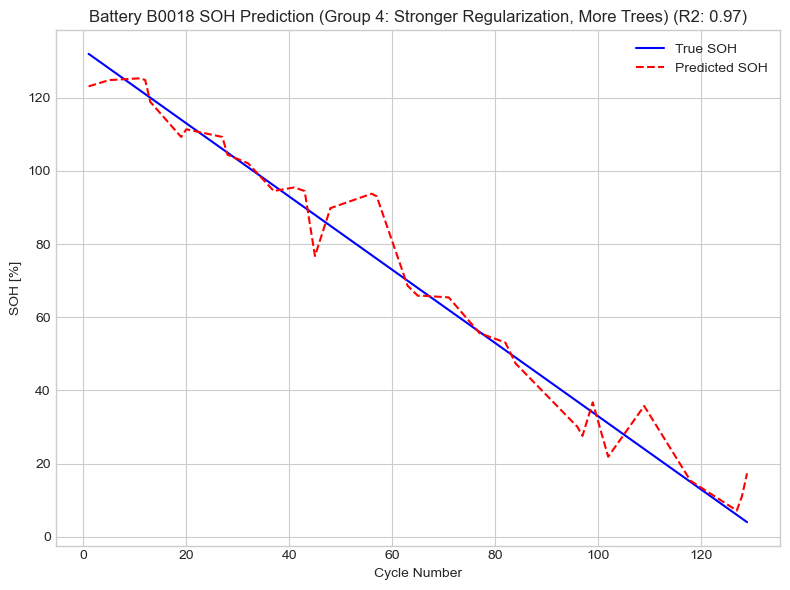


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.36 giây
R-squared for B0018: 0.9672
MAE for B0018: 5.1120
RMSE for B0018: 6.9314


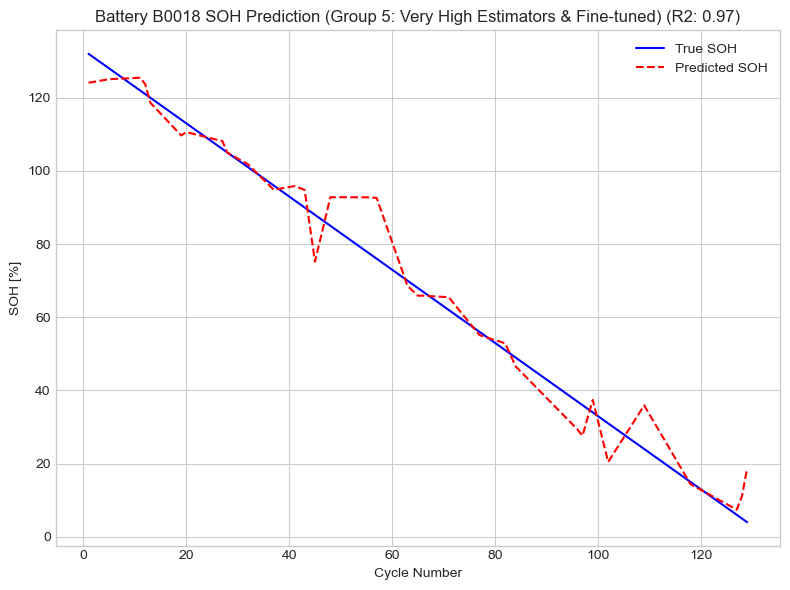

In [41]:
# Trích xuất X và Y cho pin B0008
X_B0018 = df_B0018[feature_columns]
y_B0018 = df_B0018[target_column]
cycles_B0018 = df_B0018[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0018 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0018)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0018, y_B0018, test_size=0.25, random_state=42
    )
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    # Huấn luyện mô hình Random Forest-
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R-squared for B0018: {battery_r2:.4f}")
    print(f"MAE for B0018: {battery_mae:.4f}")
    print(f"RMSE for B0018: {battery_rmse:.4f}")
    metrics_validate_xgb_B0018.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    test_cycle_data_for_plot = cycles_B0018.loc[y_test.index].sort_values()
    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 1:
        result_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--') 
    ax.set_title(f'Battery B0018 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True) 
    plt.tight_layout()
    plt.show() 
    plt.close(fig)

In [36]:
for i in range(5):
    print(f'Mean R-square group {i + 1}: ', (metrics_validate_xgb_B0018[i]['r2'] + metrics_validate_xgb_B0005[i]['r2'] + metrics_validate_xgb_B0006[i]['r2'] + metrics_validate_xgb_B0007[i]['r2']) / 4)
    print(f'Mean MAE group {i + 1}: ', (metrics_validate_xgb_B0005[i]['mae'] + metrics_validate_xgb_B0006[i]['mae'] + metrics_validate_xgb_B0007[i]['mae'] + metrics_validate_xgb_B0018[i]['mae']) / 4)
    print(f'Mean RMSE group {i + 1}: ', (metrics_validate_xgb_B0005[i]['rmse'] + metrics_validate_xgb_B0006[i]['rmse'] + metrics_validate_xgb_B0007[i]['rmse'] + metrics_validate_xgb_B0018[i]['rmse']) / 4)

Mean R-square group 1:  0.9812630712985992
Mean MAE group 1:  3.965966498027697
Mean RMSE group 1:  5.687728376897327
Mean R-square group 2:  0.9793458580970764
Mean MAE group 2:  3.941403490198633
Mean RMSE group 2:  5.963539871653348
Mean R-square group 3:  0.9824518412351608
Mean MAE group 3:  3.7127534541716187
Mean RMSE group 3:  5.489260483937008
Mean R-square group 4:  0.9821850806474686
Mean MAE group 4:  3.7048272194923655
Mean RMSE group 4:  5.52973285809354
Mean R-square group 5:  0.9808370172977448
Mean MAE group 5:  3.8504755923851954
Mean RMSE group 5:  5.748859763722158


In [43]:
print(type(result_xgb[0]))

<class 'pandas.core.frame.DataFrame'>


In [47]:

result_xgb[3].to_csv('./result/rul_split/rul_xgb_b0018.csv')

# STACKING ENSEMBLE

In [48]:
# --- Định nghĩa các nhóm/cấp độ siêu tham số cho từng base learner ---

param_levels = {
    'rf': {
        'simple': {
            'n_estimators': [100],
            'max_depth': [5, 10],
            'min_samples_split': [10],
            'min_samples_leaf': [5],
            'max_features': ['sqrt']
        },
        'moderate': {
            'n_estimators': [150, 200],
            'max_depth': [10, 15], # None cho phép cây phát triển đầy đủ
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt']
        },
        'complex': {
            'n_estimators': [200, 300],
            'max_depth': [15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt'] # Thử cả tỷ lệ feature
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'max_depth': [20, 30],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': ['sqrt'] # 'auto' = all features
        }
    },
    'xgb': {
        'simple': {
            'n_estimators': [100],
            'learning_rate': [0.1],
            'max_depth': [3, 5],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'gamma': [0, 0.1]
        },
        'moderate': {
            'n_estimators': [150, 200],
            'learning_rate': [0.05],
            'max_depth': [5, 7],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8],
            'gamma': [0, 0.1],
            'reg_alpha': [0, 0.01],
            'reg_lambda': [1, 0.1] # Lambda thường > Alpha
        },
        'complex': {
            'n_estimators': [200, 300],
            'learning_rate': [0.01], # Learning rate nhỏ hơn với nhiều cây hơn
            'max_depth': [7, 9],
            'subsample': [0.6, 0.7],
            'colsample_bytree': [0.6, 0.7],
            'gamma': [0.1, 0.2],
            'reg_alpha': [0.01, 0.1],
            'reg_lambda': [0.1, 0.5]
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'learning_rate': [0.01],
            'max_depth': [9, 12],
            'subsample': [0.5, 0.6],
            'colsample_bytree': [0.5, 0.6],
            'gamma': [0.2, 0.5],
            'reg_alpha': [0.1, 0.5],
            'reg_lambda': [0.5, 1]
        }
    },
    'svr': {
        'simple': {
            'C': [1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale'], # 'scale' là lựa chọn an toàn
            'epsilon': [0.1]
        },
        'moderate': {
            'C': [10, 50],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.01],
            'epsilon': [0.05, 0.1],
            'degree': [2, 3] # Cho poly
        },
        'complex': {
            'C': [50, 100],
            'kernel': ['rbf', 'poly'],
            'gamma': [0.001, 0.01, 0.1], # Giá trị gamma cụ thể
            'epsilon': [0.01, 0.05],
            'degree': [3, 4]
        },
        'very_complex': {
            'C': [100, 200],
            'kernel': ['rbf'], # RBF thường linh hoạt nhất
            'gamma': [0.0001, 0.001, 0.01],
            'epsilon': [0.005, 0.01],
            # 'degree' không cần nếu chỉ dùng RBF
        }
    },
    'gpr': {
        # Tinh chỉnh GPR kernel phức tạp hơn, cần định nghĩa các kernel ứng viên
        # Ở đây, chúng ta sẽ tập trung vào các tham số alpha và n_restarts
        # và giả sử bạn sẽ định nghĩa một vài kernel candidates riêng
        'simple': {
            # 'kernel': [kernel_simple_1, kernel_simple_2], # Bạn cần định nghĩa các kernel này
            'alpha': [1e-5, 1e-3],
            'n_restarts_optimizer': [5]
        },
        'moderate': {
            # 'kernel': [kernel_moderate_1, kernel_moderate_2],
            'alpha': [1e-7, 1e-5],
            'n_restarts_optimizer': [10]
        },
        'complex': {
            # 'kernel': [kernel_complex_1, kernel_complex_2],
            'alpha': [1e-9, 1e-7],
            'n_restarts_optimizer': [15]
        },
        'very_complex': {
            # 'kernel': [kernel_very_complex_1, kernel_very_complex_2],
            'alpha': [1e-10, 1e-9],
            'n_restarts_optimizer': [20]
        }
    },
    'ridge': { # Siêu tham số cho Meta-Learner (Ridge Regression)
        'simple': {'alpha': [1.0, 5.0, 10.0]},
        'moderate': {'alpha': [0.1, 0.5, 1.0, 2.0]},
        'complex': {'alpha': [0.01, 0.05, 0.1, 0.5]}, # Alpha nhỏ hơn cho phép phức tạp hơn
        'very_complex': {'alpha': [0.001, 0.005, 0.01, 0.05]}
    }
}


In [49]:
# --- Cấp độ 'simple' ---
num_features = 7
from sklearn.gaussian_process.kernels import (
    RBF,
    Matern,
    RationalQuadratic,
    ExpSineSquared,
    DotProduct,
    ConstantKernel as C, # Đổi tên để tránh nhầm lẫn với hằng số C của SVR
    WhiteKernel,
    PairwiseKernel # Cho phép sử dụng các kernel của scikit-learn như linear, rbf, poly
)
# Kernel RBF đơn giản với length_scale vô hướng (isotropic)
kernel_gpr_simple_rbf = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + \
                        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern đơn giản (nu=1.5 là một lựa chọn phổ biến, ít "mượt" hơn RBF)
kernel_gpr_simple_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                           WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'moderate' ---
# Kernel RBF với length_scale riêng cho từng chiều (anisotropic)
# Điều này rất quan trọng nếu các feature có thang đo hoặc tầm quan trọng khác nhau.
kernel_gpr_moderate_rbf_aniso = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2)) + \
                                WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern anisotropic
kernel_gpr_moderate_matern_aniso = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                                   WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Rational Quadratic (có thể nắm bắt các biến đổi ở nhiều thang đo)
kernel_gpr_moderate_rq = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1, length_scale_bounds=(1e-2,1e2), alpha_bounds=(1e-2,1e2)) + \
                         WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'complex' ---
# Kết hợp RBF anisotropic và một kernel DotProduct (tuyến tính)
# Có thể hữu ích nếu có cả thành phần phi tuyến và tuyến tính trong dữ liệu
kernel_gpr_complex_rbf_dot = C(1.0) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                             C(1.0) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-2, 1e2)) + \
                             WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))

# Kernel RBF với length_scale bounds chặt hơn, cho phép tinh chỉnh kỹ hơn
kernel_gpr_complex_rbf_tight_bounds = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                                      WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))


# Kernel ExpSineSquared (cho dữ liệu có tính chu kỳ, có thể không phù hợp lắm với SOH trừ khi có yếu tố chu kỳ mạnh)
# Ở đây chỉ để minh họa sự đa dạng. Cần điều chỉnh `periodicity`.
# kernel_gpr_complex_expsine = C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=10.0, # periodicity cần được ước lượng từ dữ liệu
# length_scale_bounds=(1e-1,1e1), periodicity_bounds=(1.0, 50.0)
#                                                       ) + \
#                              WhiteKernel(noise_level=0.01)

# --- Cấp độ 'very_complex' ---
# Một kernel phức tạp hơn bằng cách cộng nhiều thành phần RBF với các length_scale khác nhau (ARD - Automatic Relevance Determination)
# Điều này cho phép mô hình nắm bắt các cấu trúc ở các "tần số" khác nhau.
kernel_gpr_very_complex_sum_rbf = C(1.0) * RBF(length_scale=np.ones(num_features)*0.5, length_scale_bounds=(1e-2, 1e1)) + \
                                  C(1.0) * RBF(length_scale=np.ones(num_features)*2.0, length_scale_bounds=(1e-1, 1e2)) + \
                                  WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Kết hợp Matern (nu=2.5, mượt hơn nu=1.5) với một thành phần tuyến tính
kernel_gpr_very_complex_matern_dot = C(1.0) * Matern(length_scale=np.ones(num_features), nu=2.5, length_scale_bounds=(1e-2, 1e1)) + \
                                     C(1.0) * DotProduct(sigma_0=0.5, sigma_0_bounds=(1e-3, 1e1)) + \
                                     WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Sử dụng PairwiseKernel để bọc một kernel RBF từ scikit-learn (chỉ để minh họa, thường dùng RBF trực tiếp của GPR tốt hơn)
# from sklearn.metrics.pairwise import rbf_kernel
# kernel_gpr_very_complex_pairwise = C(1.0) * PairwiseKernel(gamma=0.1, metric='rbf') + \
# WhiteKernel(noise_level=0.005)

# --- Cập nhật param_levels['gpr']['kernel'] ---
# Tạo một kernel mặc định an toàn phòng trường hợp num_features không đúng
default_gpr_kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

if 'param_levels' not in globals(): # Nếu param_levels chưa được định nghĩa ở đâu đó
    param_levels = {'gpr': {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}}


param_levels['gpr']['simple']['kernel'] = [kernel_gpr_simple_rbf, kernel_gpr_simple_matern]
param_levels['gpr']['moderate']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]
param_levels['gpr']['complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]# Bỏ ExpSine nếu không chắc
param_levels['gpr']['very_complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]

# Đảm bảo các cấp độ GPR khác trong param_levels cũng được khởi tạo nếu cần
for model_name in ['rf', 'xgb', 'svr', 'ridge']:
    if model_name not in param_levels:
        param_levels[model_name] = {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}



if 'param_levels' in globals(): # Chỉ chạy nếu param_levels đã được định nghĩa
    param_levels['gpr']['simple'].update({
        'alpha': [1e-5, 1e-3],
        'n_restarts_optimizer': [5]
    })
    param_levels['gpr']['moderate'].update({
        'alpha': [1e-7, 1e-5],
        'n_restarts_optimizer': [10]
    })
    param_levels['gpr']['complex'].update({
        'alpha': [1e-9, 1e-7],
        'n_restarts_optimizer': [15]
    })
    param_levels['gpr']['very_complex'].update({
        'alpha': [1e-10, 1e-9],
        'n_restarts_optimizer': [20]
    })

    # In ra để kiểm tra một cấp độ
    print("\nVí dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:")
    print(param_levels['gpr']['moderate'])

else:
    print("Cảnh báo: 'param_levels' chưa được định nghĩa. Không thể cập nhật alpha và n_restarts cho GPR.")


Ví dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:
{'alpha': [1e-07, 1e-05], 'n_restarts_optimizer': [10], 'kernel': [1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.05), 1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.05), 1**2 * RationalQuadratic(alpha=0.1, length_scale=1) + WhiteKernel(noise_level=0.05)]}


In [50]:

# --- BƯỚC 1: KHỞI TẠO BASE LEARNERS (CHỈ LÀ TEMPLATE BAN ĐẦU) ---
rf_model_template = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_model_template = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
svr_model_template = SVR()
gpr_model_template = GaussianProcessRegressor(random_state=42) # Kernel sẽ được set bởi GridSearchCV

base_learner_templates = [ # Danh sách các template ban đầu
    ('rf', rf_model_template),
    ('xgb', xgb_model_template),
    ('svr', svr_model_template),
    ('gpr', gpr_model_template)
]
# Nếu không có feature, loại bỏ GPR
if num_features == 0 and 'gpr' in [name for name,_ in base_learner_templates]:
    base_learner_templates = [tpl for tpl in base_learner_templates if tpl[0] != 'gpr']
    print("CẢNH BÁO: GPR đã bị loại bỏ do không có features.")

In [51]:
metrics_validate_B0005 = []
metrics_validate_B0006 = []
metrics_validate_B0007 = []
metrics_validate_B0018 = []

In [64]:
X_full = df_B0018[feature_columns]
y_full = df_B0018[target_column]
groups_full = df_B0018[group_column]

# Tính toán số lượng features
num_features = X_full.shape[1] # <<< ĐỊNH NGHĨA num_features TỪ X_full
# --- 2. CHIA TẬP DỮ LIỆU TRAINING/TESTING (75% TRAIN, 25% TEST) ---
print("--- Chia dữ liệu Training (75%) và Testing (25%) ---")
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X_full, y_full, groups_full, test_size=0.25, random_state=42, shuffle=True
)

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước y_test: {y_test.shape}")
print(f"Số lượng nhóm duy nhất trong tập train: {groups_train.nunique()}")
print(f"Số lượng nhóm duy nhất trong tập test: {groups_test.nunique()}")

--- Chia dữ liệu Training (75%) và Testing (25%) ---
Kích thước X_train: (99, 5)
Kích thước X_test: (33, 5)
Kích thước y_train: (99,)
Kích thước y_test: (33,)
Số lượng nhóm duy nhất trong tập train: 1
Số lượng nhóm duy nhất trong tập test: 1


# Training base model

In [65]:
current_level_to_try = 'simple'
print(f"\n--- SỬ DỤNG CẤP ĐỘ THAM SỐ: {current_level_to_try.upper()} ---")


# --- 3. HUẤN LUYỆN BASE LEARNERS VÀ TẠO META-FEATURES ---
print("\n--- Bắt đầu huấn luyện Base Learners và tạo Meta-Features ---")
start_time_base_learners = time.time()

# Khởi tạo mảng để lưu trữ dự đoán của base learners
oof_predictions_base_train = np.zeros((len(X_train), len(base_learner_templates)))
test_predictions_base = np.zeros((len(X_test), len(base_learner_templates)))
best_params_per_learner = [] # Lưu trữ best_params cho mỗi base learner

# Inner CV sẽ luôn là KFold vì chỉ có một battery_id trong df_B0005
n_inner_cv_splits = min(5, len(X_train)) # Sử dụng 5 fold cho inner CV, hoặc ít hơn nếu X_train nhỏ
if n_inner_cv_splits == 0: n_inner_cv_splits = 1 # Đảm bảo ít nhất 1 split
inner_cv = KFold(n_splits=n_inner_cv_splits, shuffle=True, random_state=42)
print(f"  Inner CV cho Base Learners: KFold với {inner_cv.n_splits} splits")

for i_learner, (learner_name, model_template) in enumerate(base_learner_templates):
    start_time_learner = time.time()
    print(f"\n  Tinh chỉnh và huấn luyện Base Learner: {learner_name}")

    if learner_name not in param_levels or current_level_to_try not in param_levels[learner_name]:
        print(f"Cảnh báo: Không tìm thấy param grid cho {learner_name} ở level {current_level_to_try}. Bỏ qua.")
        oof_predictions_base_train[:, i_learner] = np.nan
        test_predictions_base[:, i_learner] = np.nan
        continue

    param_grid_learner = param_levels[learner_name][current_level_to_try]

    grid_search_cv = GridSearchCV(
        estimator=clone(model_template),
        param_grid=param_grid_learner,
        scoring='neg_root_mean_squared_error',
        cv=inner_cv, # KFold trên X_train
        n_jobs=1,
        verbose=0
    )

    try:
        grid_search_cv.fit(X_train, y_train) # Không cần groups vì dùng KFold

        best_model_for_learner = grid_search_cv.best_estimator_

        # Tạo meta-features: dự đoán trên X_train và X_test
        oof_predictions_base_train[:, i_learner] = best_model_for_learner.predict(X_train)
        test_predictions_base[:, i_learner] = best_model_for_learner.predict(X_test)

        print(f"    Best params cho {learner_name}: {grid_search_cv.best_params_}")
        print(f"    Best CV score (neg_RMSE): {grid_search_cv.best_score_:.4f}")
        best_params_per_learner.append({
            'learner': learner_name,
            'best_params': grid_search_cv.best_params_,
            'best_cv_score': grid_search_cv.best_score_
        })

    except Exception as e:
        print(f"    LỖI với GridSearchCV cho {learner_name}: {e}")
        oof_predictions_base_train[:, i_learner] = np.nan
        test_predictions_base[:, i_learner] = np.nan

    end_time_learner = time.time()
    print(f"    Thời gian cho {learner_name}: {end_time_learner - start_time_learner:.2f} giây")

end_time_base_learners = time.time()
print(f"\nHoàn thành huấn luyện Base Learners. Tổng thời gian: {end_time_base_learners - start_time_base_learners:.2f} giây")

best_params_df = pd.DataFrame(best_params_per_learner)
print("\n--- Siêu tham số tốt nhất cho Base Learners ---")
print(best_params_df)

# Chuyển đổi thành DataFrame và xử lý NaN nếu có
meta_features_for_meta_train = pd.DataFrame(oof_predictions_base_train, columns=[name for name, _ in base_learner_templates])
meta_features_for_meta_test = pd.DataFrame(test_predictions_base, columns=[name for name, _ in base_learner_templates])

for col in meta_features_for_meta_train.columns:
    if meta_features_for_meta_train[col].isnull().any():
        print(f"Cảnh báo: Tìm thấy NaN trong meta-features train của {col}. Điền bằng giá trị trung bình.")
        if not meta_features_for_meta_train[col].isnull().all():
            mean_val = meta_features_for_meta_train[col].mean()
            meta_features_for_meta_train[col].fillna(mean_val, inplace=True)
            meta_features_for_meta_test[col].fillna(mean_val, inplace=True) # Điền giá trị trung bình từ tập train
        else: # Nếu tất cả đều NaN
            meta_features_for_meta_train[col].fillna(0, inplace=True)
            meta_features_for_meta_test[col].fillna(0, inplace=True)



--- SỬ DỤNG CẤP ĐỘ THAM SỐ: SIMPLE ---

--- Bắt đầu huấn luyện Base Learners và tạo Meta-Features ---
  Inner CV cho Base Learners: KFold với 5 splits

  Tinh chỉnh và huấn luyện Base Learner: rf
    Best params cho rf: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
    Best CV score (neg_RMSE): -8.8873
    Thời gian cho rf: 1.23 giây

  Tinh chỉnh và huấn luyện Base Learner: xgb
    Best params cho xgb: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
    Best CV score (neg_RMSE): -6.1957
    Thời gian cho xgb: 0.67 giây

  Tinh chỉnh và huấn luyện Base Learner: svr
    Best params cho svr: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    Best CV score (neg_RMSE): -8.4120
    Thời gian cho svr: 0.11 giây

  Tinh chỉnh và huấn luyện Base Learner: gpr
    Best params cho gpr: {'alpha': 0.001, 'kernel': 1**2 * RBF(length_scale=1) + WhiteK

# META LEARNER

In [66]:
# --- 4. TINH CHỈNH VÀ HUẤN LUYỆN META-LEARNER (Ridge Regression) ---
print("\n--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---")
meta_learner_template = Ridge(random_state=42)
param_grid_meta = param_levels['ridge'][current_level_to_try]

# CV cho meta-learner: KFold trên tập huấn luyện
n_meta_cv_splits = min(5, len(meta_features_for_meta_train))
if n_meta_cv_splits == 0: n_meta_cv_splits = 1
cv_meta = KFold(n_splits=n_meta_cv_splits, shuffle=True, random_state=42)
print(f"  CV cho Meta-Learner: KFold với {cv_meta.n_splits} splits")

grid_search_meta = GridSearchCV(
    estimator=meta_learner_template,
    param_grid=param_grid_meta,
    scoring='neg_root_mean_squared_error',
    cv=cv_meta,
    n_jobs=1,
    verbose=1
)

if meta_features_for_meta_train.empty or y_train.empty:
    print("Cảnh báo: Dữ liệu meta-features hoặc target train rỗng, không thể tinh chỉnh Meta-Learner.")
else:
    grid_search_meta.fit(meta_features_for_meta_train, y_train) # Huấn luyện trên meta-features từ X_train

    best_meta_learner = grid_search_meta.best_estimator_
    print(f"\nMeta-Learner tốt nhất: {best_meta_learner}")
    print(f"Hệ số của Meta-Learner tốt nhất: {best_meta_learner.coef_}")
    print(f"Best CV score (neg_RMSE) cho Meta-Learner: {grid_search_meta.best_score_:.4f}")


    # --- 5. ĐÁNH GIÁ MÔ HÌNH STACKING TỔNG THỂ TRÊN TẬP TEST ---
    print("\n--- Đánh giá Mô hình STACKING trên tập TEST ---")
    final_stacking_predictions = best_meta_learner.predict(meta_features_for_meta_test)

    # Tính toán các chỉ số
    test_rmse_stacking = np.sqrt(mean_squared_error(y_test, final_stacking_predictions))
    test_r2_stacking = r2_score(y_test, final_stacking_predictions)
    test_mae_stacking = mean_absolute_error(y_test, final_stacking_predictions)

    print(f"  RMSE trên tập TEST: {test_rmse_stacking:.4f}")
    print(f"  R2 score trên tập TEST: {test_r2_stacking:.4f}")
    print(f"  MAE trên tập TEST: {test_mae_stacking:.4f}")


    print(len(final_stacking_predictions))


--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---
  CV cho Meta-Learner: KFold với 5 splits
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Meta-Learner tốt nhất: Ridge(random_state=42)
Hệ số của Meta-Learner tốt nhất: [-0.01357024  1.03709497  0.00507812 -0.02831908]
Best CV score (neg_RMSE) cho Meta-Learner: -0.2684

--- Đánh giá Mô hình STACKING trên tập TEST ---
  RMSE trên tập TEST: 7.1594
  R2 score trên tập TEST: 0.9650
  MAE trên tập TEST: 5.3779
33


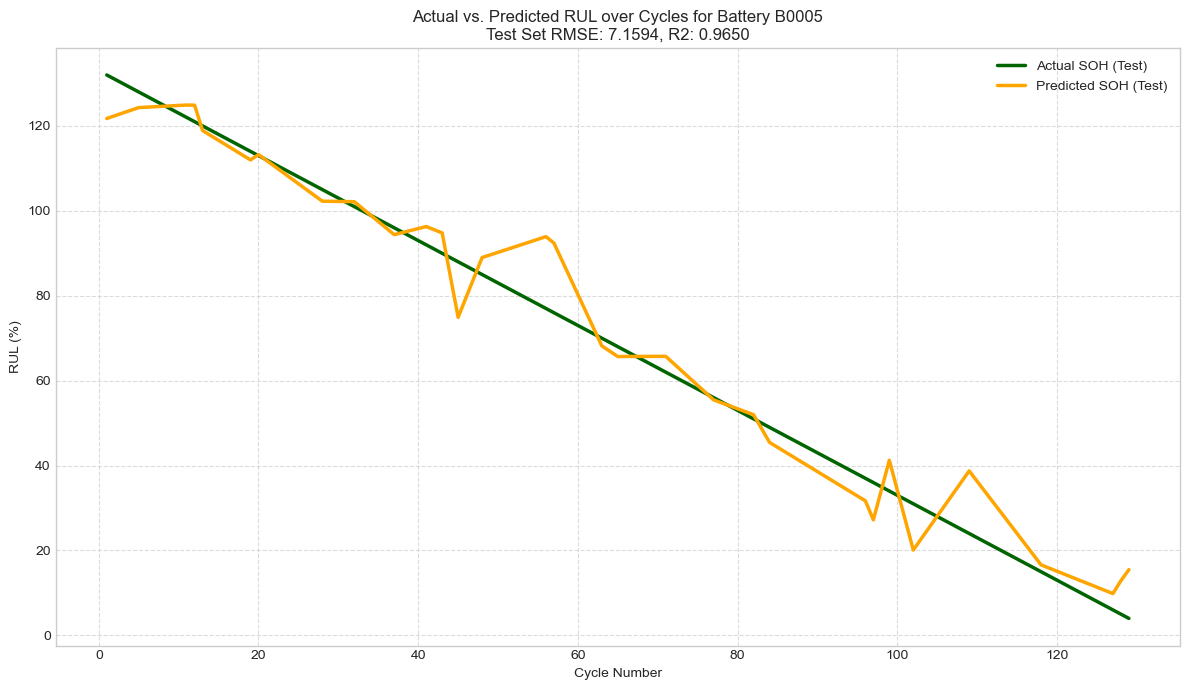

In [67]:

if y_test.empty or y_train.empty or final_stacking_predictions.size == 0:
    print("Không thể vẽ đồ thị SOH/CYCLE: Dữ liệu huấn luyện hoặc kiểm tra rỗng / không có dự đoán.")
else:
    # --- 1. Tạo DataFrame cho dữ liệu Test Set ---
    # train_test_split giữ nguyên index gốc, nên ta có thể dùng y_test.index
    # để lấy lại cột 'cycle' từ df_B0005 gốc.
    plot_df_test = pd.DataFrame({
        'cycle': df_B0018.loc[y_test.index, 'cycle'], # Lấy cột 'cycle' tương ứng
        'actual_soh': y_test,
        'predicted_soh': final_stacking_predictions
    })
    plot_df_test.to_csv('./result/rul_split/rul_st_b0018.csv')
    # Sắp xếp theo cycle để đường đồ thị mượt mà hơn
    plot_df_test = plot_df_test.sort_values(by='cycle')
    # --- 3. Vẽ đồ thị ---
    plt.figure(figsize=(12, 7)) # Kích thước lớn hơn cho dễ nhìn

    # Vẽ cho tập Test Set
    sns.lineplot(data=plot_df_test, x='cycle', y='actual_soh', color='darkgreen', label='Actual SOH (Test)', linewidth=2.5)
    sns.lineplot(data=plot_df_test, x='cycle', y='predicted_soh', color='orange', linestyle='-', label='Predicted SOH (Test)', linewidth=2.5)

    plt.xlabel('Cycle Number')
    plt.ylabel(f'{target_column} (%)') # Giả sử SOH là phần trăm
    plt.title(f'Actual vs. Predicted {target_column} over Cycles for Battery B0005\n'
              f'Test Set RMSE: {test_rmse_stacking:.4f}, R2: {test_r2_stacking:.4f}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()